In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
#import benchmark.models_tcrdist as models_tcrdist

# Clustering

## VDJdb

In [4]:
vdjdb_data_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv'

In [5]:

vdjdb_data = pd.read_csv(vdjdb_data_path,sep='\t')

In [6]:
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

In [8]:
def tcrdist3_dist(data_df, chain, n_clusters=None, chunk=True):
    df = data_df.copy()
    cdr3a = 'cdr3_a_aa'
    va = 'v_a_gene'
    ja = 'j_a_gene'
    cdr3b = 'cdr3_b_aa'
    vb = 'v_b_gene'
    jb = 'j_b_gene'

    if not 'count' in df.columns:
        df['count']=[1]*len(df)

    if chain == 'TRA':
        df = df[df['chain']==chain].reset_index(drop=True)
        df = df.rename(columns={'cdr3aa': cdr3a,
                                                'v': va,
                                                'j':ja})
        df = df[[cdr3a, va, ja,'antigen.epitope', 'count','data_id']]

    elif chain == 'TRB':
        df = df[df['chain']==chain].reset_index(drop=True)
        df= df.rename(columns={'cdr3aa': cdr3b,
                                                'v': vb,
                                                'j':jb})
        df = df[[cdr3b, vb, jb,'antigen.epitope', 'count','data_id']]

    else:
        pass


    seqs = df.drop(columns=['antigen.epitope','data_id'], axis=1).reset_index(drop=True)

    if chain =='TRA':
        chain1 = ['alpha']
    else:
        chain1 = ['beta']

    # Run tcrdist3

    print('\n*** Tcrdist3 clustering %s %s chains ' % (len(seqs), chain))

    t0 = time.time()

    # Create tcrdist object
    tr = TCRrep(cell_df=seqs,   # Input data
                organism='human',   # Organism
                chains=chain1,       # Chain selection
                infer_all_genes=True,   # Infer genes
                infer_cdrs=True,        # Infer CDRs
                infer_index_cols=True,  # Infer column names
                store_all_cdr=True,     # Store CDRs
                deduplicate=False,      # Deduplicate
                compute_distances=False)    # Compute distances
    return tr, df
    
    # Compute tcrdist distances using sparse rect distances
def tcrdist3_compute(tr, chain, cpus, radius=50):
    if chain =='TRA':
        chain1 = ['alpha']
        name = 'alpha'
    else:
        chain1 = ['beta']
        name = 'beta'


    S, _ = compute_pw_sparse_out_of_memory2(tr = tr,
        row_size      = 50,
        pm_processes  = cpus,
        pm_pbar       = True,
        max_distance  = radius,
        reassemble    = True,
        cleanup       = True,
        assign        = True)
    S=S[name]

    return S   

    # Cluster tcrdist matrix
def tcrdust3_cluster(S, chain, n_clusters):
    if not n_clusters:
        n_clusters=500
    kmeans = KMeans(init='random',
                    n_init=10,
                    n_clusters=int(n_clusters)).fit(S)
    labels = kmeans.labels_
    
    pd.DataFrame(labels).to_csv()

    return labels

def run_tcrdist3(vdjdb_data_tcrdist3, chain, n_clusters):
    tcrdist3_tr, tcrdist_data = tcrdist3_dist(vdjdb_data_tcrdist3,chain)
    tcrdist3_s = tcrdist3_compute(tcrdist3_tr,chain,2)
    tcrdist3_labels = tcrdust3_cluster(tcrdist3_s, chain, n_clusters)
    tcrdist_data['cluster']= tcrdist3_labels
    binom_res = ml_utils.binominal_test(tcrdist_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    tcrdist_data = tcrdist_data.merge(binom_res)
    tcrdist_data.to_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
    return tcrdist_data


def run_GIANA(data_df, chain, cpus):
    '''Run GIANA clustering algorithm
'''
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    # Reformat input for GIANA
    seqs = df[['CDR3','V']]

    #save data for GIANA
    cdir = os.getcwd()
    giana_path = os.path.join(cdir, 'benchmark/GIANA/')
    os.chdir(giana_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('GIANA clustering of {} sequences.'.format(len(df)))

    # Run GIANA
    t0 = time.time()
    os.system('python GIANA4.1.py -f data.txt -O data_clustered.txt -v True -N {}'.format(cpus))
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(giana_path, 'data_clustered.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'cluster',
                                                                            'V',
                                                                         ])   
    os.chdir(cdir)
    
    giana_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(giana_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    giana_data = giana_data.merge(binom_res)
    giana_data.to_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')

    return giana_data

In [9]:
def run_ismart(data_df, chain_selection,cpus):
    
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    
    # Reformat input for iSMART
    seqs = df[['CDR3','V']]

    #save data for iSMART
    cdir = os.getcwd()
    ismart_path = os.path.join(cdir, 'benchmark/iSMART/')
    os.chdir(ismart_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('Clustering {} sequences with iSMART.'.format(len(df)))
    
    
    t0 = time.time()
    #os.system('python iSMARTf3.py -f input.txt -v True -N {}'.format(cpus))
    os.system('python iSMARTf3.py -f data.txt')
    t1 = time.time()
    t = t1 - t0
    
    
    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(ismart_path, 'data_clustered_v3.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'V',
                                                                            'cluster',
                                                                         ])   
    os.chdir(cdir)
    
    ismart_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(ismart_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    ismart_data = ismart_data.merge(binom_res)
    ismart_data.to_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')

    return ismart_data

### TCRDIST3

In [58]:
vdjdb_data_tcrdist3 = vdjdb_data.copy()
vdjdb_data_tcrdist3['v']= vdjdb_data_tcrdist3['v'] + '*01'
vdjdb_data_tcrdist3['j']= vdjdb_data_tcrdist3['j'] + '*01'
vdjdb_data_tcrdist3['v'] = vdjdb_data_tcrdist3['v'].str.replace('DV','/DV')
vdjdb_data_tcrdist3

,chain,cdr3aa,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v,j,v.end,...,antigen.epitope_freq_500,antigen.epitope_freq_1000,antigen.species_freq,antigen.species_freq_10,antigen.species_freq_20,antigen.species_freq_30,antigen.species_freq_50,antigen.species_freq_100,antigen.species_freq_500,antigen.species_freq_1000
0,TRA,CASNTGTASKLTF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV24*01,TRAJ44*01,2,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
1,TRA,CAVLLEYGNKLVF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV12-2*01,TRAJ47*01,3,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
2,TRB,CASSAFPCREGRNNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV6-1*01,TRBJ2-1*01,4,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
3,TRA,CVVSAIMDSNYQLIW,HomoSapiens,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,29700,TRAV8-2*01,TRAJ33*01,4,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
4,TRB,CASSHGVGQGPYEQYF,HomoSapiens,YLQPRTFLL,Spike,SARS-CoV-2,0,TRBV4-1*01,TRBJ2-7*01,4,...,YLQPRTFLL,YLQPRTFLL,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36188,TRB,CASSLKDSGSYEQYF,HomoSapiens,HTQGYFPD,Nef,HIV,0,TRBV4-3*01,TRBJ2-7*01,4,...,other,other,HIV,HIV,HIV,HIV,HIV,HIV,other,other
36189,TRA,CAMRELSNTGKLIF,HomoSapiens,NSAIGKIQY,Spike,SARS-CoV-2,29257,TRAV14/DV4*01,TRAJ37*01,5,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
36190,TRA,CALSEASGYSTLTF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV19*01,TRAJ11*01,5,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
36191,TRB,CASSQPQGPTDTQYF,HomoSapiens,GLIYNRMGAVTTEV,M1,InfluenzaA,0,TRBV6-6*01,TRBJ2-3*01,4,...,other,other,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA


In [59]:
tcrdist_res = {}
metrics_tcrdist = {}

In [ ]:
chain = 'TRA'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

In [11]:
chain = 'TRB'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=10616)


*** Tcrdist3 clustering 24146 TRB chains 
CREATED /c13d76564a5c/ FOR HOLDING DISTANCE OUT OF MEMORY
RETURNING scipy.sparse csr_matrix w/dims (24146, 24146)
CLEANING UP c13d76564a5c


In [60]:
chain = 'TRA'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')

In [61]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6054879190571456, 'precision': 0.6238795737186192, 'recall': 0.6227276500373538}
0.5125482625482626


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
chain = 'TRB'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
tcrdist_res[chain]['is_cluster'] = tcrdist_res[chain]['total_cluster'].apply(lambda x: 1 if x>1 else 0)

In [63]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6007437333353057, 'precision': 0.6546664311651285, 'recall': 0.6065600927689887}
0.4703980376853607


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
chain = 'TRA'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

{'purity': 0.5125482625482626,
 'retention': 0.7739686228936665,
 'consistency': 0.00015951065569386178,
 'ami': 0.32600384549182043,
 'accuracy': 0.00010723860466460209,
 'precision': 0.4877281770379499,
 'recall': 0.5125482625482611,
 'f1-score': 0.49983028659566164,
 'support': 9324,
 'mean_clustsize': 3.625194401244168}

In [65]:
chain = 'TRB'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

{'purity': 0.4703980376853607,
 'retention': 0.7428973743063033,
 'consistency': 0.00022685921679757088,
 'ami': 0.31242420271498356,
 'accuracy': 5.574446718837214e-05,
 'precision': 0.49837505679032795,
 'recall': 0.4703980376853594,
 'f1-score': 0.4839825756564367,
 'support': 17938,
 'mean_clustsize': 4.069419237749546}

### GIANA

In [7]:
vdjdb_data_giana = vdjdb_data.copy()
vdjdb_data_giana['v']= vdjdb_data_giana['v'] + '*01'
vdjdb_data_giana['j']= vdjdb_data_giana['j'] + '*01'
vdjdb_data_giana

,chain,cdr3aa,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v,j,v.end,...,antigen.epitope_freq_500,antigen.epitope_freq_1000,antigen.species_freq,antigen.species_freq_10,antigen.species_freq_20,antigen.species_freq_30,antigen.species_freq_50,antigen.species_freq_100,antigen.species_freq_500,antigen.species_freq_1000
0,TRA,CASNTGTASKLTF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV24*01,TRAJ44*01,2,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
1,TRA,CAVLLEYGNKLVF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV12-2*01,TRAJ47*01,3,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
2,TRB,CASSAFPCREGRNNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV6-1*01,TRBJ2-1*01,4,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
3,TRA,CVVSAIMDSNYQLIW,HomoSapiens,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,29700,TRAV8-2*01,TRAJ33*01,4,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
4,TRB,CASSHGVGQGPYEQYF,HomoSapiens,YLQPRTFLL,Spike,SARS-CoV-2,0,TRBV4-1*01,TRBJ2-7*01,4,...,YLQPRTFLL,YLQPRTFLL,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36188,TRB,CASSLKDSGSYEQYF,HomoSapiens,HTQGYFPD,Nef,HIV,0,TRBV4-3*01,TRBJ2-7*01,4,...,other,other,HIV,HIV,HIV,HIV,HIV,HIV,other,other
36189,TRA,CAMRELSNTGKLIF,HomoSapiens,NSAIGKIQY,Spike,SARS-CoV-2,29257,TRAV14DV4*01,TRAJ37*01,5,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
36190,TRA,CALSEASGYSTLTF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV19*01,TRAJ11*01,5,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
36191,TRB,CASSQPQGPTDTQYF,HomoSapiens,GLIYNRMGAVTTEV,M1,InfluenzaA,0,TRBV6-6*01,TRBJ2-3*01,4,...,other,other,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA


In [8]:
giana_res_raw = {}
giana_res= {}
metrics_giana = {}


In [9]:
#giana_res_raw_s = {}
#giana_res_s= {}
metrics_giana_s = {}

In [36]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

GIANA clustering of 12047 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.091597
Maximum memory usage: 0.195924 MB
Elapsed time: 6.913618326187134 seconds.


In [37]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

GIANA clustering of 12047 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.111440
Maximum memory usage: 0.195912 MB
Elapsed time: 6.895632982254028 seconds.


In [38]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

GIANA clustering of 24146 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.258025
Maximum memory usage: 0.213076 MB
Elapsed time: 7.099045276641846 seconds.


In [39]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

GIANA clustering of 24146 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.281960
Maximum memory usage: 0.213180 MB
Elapsed time: 7.119290590286255 seconds.


#### metrics epitope

In [10]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [11]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.44469108692745407, 'precision': 0.445177272567925, 'recall': 0.4825250192455735}
0.4825250192455735


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

{'purity': 0.4825250192455735,
 'retention': 0.5391383746990952,
 'consistency': 0.0002669033901681939,
 'ami': 0.2770754899951193,
 'accuracy': 0.00015394088305032414,
 'precision': 0.44517727256792533,
 'recall': 0.4825250192455726,
 'f1-score': 0.46309936691783915,
 'support': 6495,
 'mean_clustsize': 5.2591093117408905}

In [13]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [14]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.6677369627522027, 'precision': 0.6611237871815081, 'recall': 0.6917443408788282}
0.6917443408788282


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

{'purity': 0.6917443408788282,
 'retention': 0.24881968027830698,
 'consistency': 0.0004080693529076077,
 'ami': 0.6144344860542508,
 'accuracy': 0.00016641703649461614,
 'precision': 0.6611237871815083,
 'recall': 0.6917443408788297,
 'f1-score': 0.6760875342061295,
 'support': 6008,
 'mean_clustsize': 3.5361977633902297}

#### metrics species

In [16]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.5740369839523196, 'precision': 0.5802223295511171, 'recall': 0.581370284834488}
0.581370284834488


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

{'purity': 0.581370284834488,
 'retention': 0.5391383746990952,
 'consistency': 0.002262095102741754,
 'ami': 0.2460875892322585,
 'accuracy': 0.004603292282036101,
 'precision': 0.580222329551117,
 'recall': 0.581370284834488,
 'f1-score': 0.5807957399537738,
 'support': 6495,
 'mean_clustsize': 5.2591093117408905}

In [18]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.7536828276986148, 'precision': 0.7554238533592089, 'recall': 0.7583222370173103}
0.7583222370173103


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

{'purity': 0.7583222370173103,
 'retention': 0.24881968027830698,
 'consistency': 0.002557700843320017,
 'ami': 0.546042795855279,
 'accuracy': 0.005644050276506602,
 'precision': 0.755423853359209,
 'recall': 0.7583222370173103,
 'f1-score': 0.7568702704072435,
 'support': 6008,
 'mean_clustsize': 3.5361977633902297}

### TCRemb

In [20]:
tcremb_res = {}
metrics_tcremb= {}

tcremb_res_dbscan = {}
metrics_tcremb_s= {}
metrics_tcremb_dbscan= {}
metrics_tcremb_dbscan_s= {}
output_suf_dbscan = output_suf + '_dbscan'
output_suf_dbscan_s = output_suf + '_dbscan_s'

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [66]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan, skip_scores=True, label=label, model='dbscan')

TCRemb clustering
python tcremb_run.py --input /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv --runname compare_vdjdb_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv
purity:0.7045454545454546
Results are in tcremb_outputs/compare_vdjdb_dbscan/
Elapsed time: 106.90597128868103 seconds.


In [67]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

TCRemb clustering
python tcremb_run.py --input /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv --runname compare_vdjdb_dbscan_s --chain TRA --label antigen.species --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv
purity:0.7705769756631118
Results are in tcremb_outputs/compare_vdjdb_dbscan_s/
Elapsed time: 106.86218357086182 seconds.


In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [68]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan,skip_scores=True ,label=label, model='dbscan')

TCRemb clustering
python tcremb_run.py --input /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv --runname compare_vdjdb_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv
purity:0.8409627182633318
Results are in tcremb_outputs/compare_vdjdb_dbscan/
Elapsed time: 232.90487456321716 seconds.


In [69]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

TCRemb clustering
python tcremb_run.py --input /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv --runname compare_vdjdb_dbscan_s --chain TRB --label antigen.species --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain /home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv
purity:0.8761792452830188
Results are in tcremb_outputs/compare_vdjdb_dbscan_s/
Elapsed time: 233.3959150314331 seconds.


#### metrics epitope

In [70]:
chain = 'TRA'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.5974704967112686, 'precision': 0.6025742420261866, 'recall': 0.6108341641741443}
0.5464756003098373


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

{'purity': 0.5464756003098373,
 'retention': 0.8580923894981721,
 'consistency': 0.0001346963508364751,
 'ami': 0.3693221355662307,
 'accuracy': 9.681479239278543e-05,
 'precision': 0.5224721618243306,
 'recall': 0.5464756003098367,
 'f1-score': 0.5342043800308602,
 'support': 10328,
 'mean_clustsize': 3.490368367691788}

In [72]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.33237462133447093, 'precision': 0.5485724932599136, 'recall': 0.3665669657693586}
0.7045454545454546


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

{'purity': 0.7045454545454546,
 'retention': 0.3034230641409106,
 'consistency': 0.0005888396708313544,
 'ami': 0.5697207799689346,
 'accuracy': 0.000273747584183193,
 'precision': 0.6846853855531007,
 'recall': 0.7045454545454531,
 'f1-score': 0.6944734629572672,
 'support': 3652,
 'mean_clustsize': 3.332116788321168}

In [74]:
chain = 'TRB'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.5990783461105398, 'precision': 0.6086569817203091, 'recall': 0.607991047374311}
0.5361224189513953


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

{'purity': 0.5361224189513953,
 'retention': 0.8450698387698429,
 'consistency': 7.733808952794299e-05,
 'ami': 0.38030166918966346,
 'accuracy': 4.9041243214062e-05,
 'precision': 0.5266511306667192,
 'recall': 0.5361224189513971,
 'f1-score': 0.531344571415022,
 'support': 20389,
 'mean_clustsize': 3.5582897033158813}

In [76]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.26988104898825616, 'precision': 0.6124416130462924, 'recall': 0.31984913167820284}
0.8409627182633318


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

{'purity': 0.8409627182633318,
 'retention': 0.17565383180668961,
 'consistency': 0.0007615084302200866,
 'ami': 0.7767021652096425,
 'accuracy': 0.0030587990052027086,
 'precision': 0.833856944243089,
 'recall': 0.840962718263331,
 'f1-score': 0.8373947573841968,
 'support': 4238,
 'mean_clustsize': 3.5228595178719866}

#### metrics species

In [78]:
chain = 'TRA'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.7205391425460803, 'precision': 0.7222203812431379, 'recall': 0.7212529079428381}
0.6583850931677019


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

{'purity': 0.6583850931677019,
 'retention': 0.8159687603855101,
 'consistency': 0.0007089871665780432,
 'ami': 0.33544326520972045,
 'accuracy': 0.0030475249352162493,
 'precision': 0.6587907827559486,
 'recall': 0.6583850931677018,
 'f1-score': 0.6585878754857182,
 'support': 9821,
 'mean_clustsize': 3.3645083932853717}

In [80]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.4147101942622497, 'precision': 0.6292214840146441, 'recall': 0.45139581256231304}
0.7705769756631118


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

{'purity': 0.7705769756631118,
 'retention': 0.3038384845463609,
 'consistency': 0.003885842580199473,
 'ami': 0.5163015692176152,
 'accuracy': 0.0019120436015630437,
 'precision': 0.7738030115431702,
 'recall': 0.7705769756631118,
 'f1-score': 0.7721866241903068,
 'support': 3657,
 'mean_clustsize': 3.330601092896175}

In [82]:
chain = 'TRB'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6433837469939494, 'precision': 0.6469627848205372, 'recall': 0.6471587847639574}
0.6008346227786374


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

{'purity': 0.6008346227786374,
 'retention': 0.883947444771418,
 'consistency': 0.0003610446851409013,
 'ami': 0.30154937343686294,
 'accuracy': 0.0015925040026466043,
 'precision': 0.5981600085167489,
 'recall': 0.6008346227786374,
 'f1-score': 0.5994943324977844,
 'support': 21327,
 'mean_clustsize': 3.7278447823807026}

In [84]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.3202842545234761, 'precision': 0.7128087281594292, 'recall': 0.3733162017656567}
0.8761792452830188


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

{'purity': 0.8761792452830188,
 'retention': 0.17573672648899574,
 'consistency': 0.0037028301886792452,
 'ami': 0.7208987687892208,
 'accuracy': 0.0004714756140975436,
 'precision': 0.8751683505111084,
 'recall': 0.8761792452830189,
 'f1-score': 0.8756735061479437,
 'support': 4240,
 'mean_clustsize': 3.521594684385382}

#### check tcremb and ismart

In [40]:
tcremb_t = tcremb_res[chain].copy()

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,j,chain,cloneId,clone_size,data_id,antigen.species,DM1,DM2,DM1_clones,DM2_clones
0,5634,0,CMV,3,6059,1,0.333333,0.251129,5.800281e-01,1,...,TRBJ2-1,TRB,8469,1,7,CMV,37.316154,-68.645730,33.798725,-67.328445
1,446,1,SARS-CoV-2,4,5128,2,0.500000,0.212542,2.003555e-01,1,...,TRBJ2-7,TRB,11476,1,13,SARS-CoV-2,-27.778635,36.042560,-20.650253,33.198196
2,7353,2,CMV,2,6059,2,1.000000,0.251129,6.306600e-02,1,...,TRBJ2-7,TRB,16075,1,14,CMV,-77.930250,-48.809166,-78.044365,-46.287210
3,1901,3,EBV,4,1615,1,0.250000,0.066937,2.420457e-01,1,...,TRBJ2-5,TRB,14433,1,26,CMV,59.741430,-59.983090,56.308216,-63.056194
4,957,4,HCV,5,1052,2,0.400000,0.043603,1.740752e-02,1,...,TRBJ2-5,TRB,6800,1,34,EBV,-57.540287,-19.260717,-49.786804,-20.558447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24122,8509,24141,HIV-1,6,2381,6,1.000000,0.098686,9.237117e-07,1,...,TRBJ2-1,TRB,21004,1,75256,HIV-1,-37.483917,13.026552,-41.958435,59.084360
24123,1305,24142,CMV,3,6059,2,0.666667,0.251129,1.575225e-01,1,...,TRBJ2-1,TRB,22116,1,75260,CMV,-39.310310,-60.719643,-38.945410,-65.169540
24124,2678,24143,HIV,7,154,5,0.714286,0.006383,2.201275e-10,1,...,TRBJ2-7,TRB,14689,1,75264,HIV,-33.735030,52.406284,-33.683610,33.010470
24125,7737,24144,CMV,3,6059,2,0.666667,0.251129,1.575225e-01,1,...,TRBJ2-3,TRB,20226,1,75274,InfluenzaA,48.042732,-76.789480,40.416912,-78.843730


In [42]:
t = ismart_res[chain][~ismart_res[chain]['cluster'].isna()]

In [46]:
len(t['cluster'].drop_duplicates())

1187

In [44]:
tcremb_t = tcremb_t[tcremb_t['data_id'].isin(t['data_id'])]
tcremb_t

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,j,chain,cloneId,clone_size,data_id,antigen.species,DM1,DM2,DM1_clones,DM2_clones
15,7379,15,SARS-CoV-2,5,5128,2,0.400000,0.212542,2.885886e-01,1,...,TRBJ1-4,TRB,16133,2,69,InfluenzaA,-6.565824,-34.128360,-16.615482,-31.981878
16,7379,7333,SARS-CoV-2,5,5128,2,0.400000,0.212542,2.885886e-01,1,...,TRBJ1-4,TRB,16133,2,22844,InfluenzaA,-6.565543,-34.130010,-16.615482,-31.981878
18,2772,17,HIV-1,2,2381,2,1.000000,0.098686,9.738950e-03,1,...,TRBJ1-2,TRB,6296,1,71,HIV-1,-52.430470,-54.270634,-51.173462,-62.170498
20,97,19,CMV,11,6059,4,0.363636,0.251129,2.898096e-01,1,...,TRBJ2-1,TRB,23446,3,79,HCV,22.629503,-91.778200,-23.932434,-90.518020
21,97,11439,CMV,11,6059,4,0.363636,0.251129,2.898096e-01,1,...,TRBJ2-1,TRB,23446,3,35368,CMV,22.629570,-91.776170,-23.932434,-90.518020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24091,1734,24110,HIV-1,5,2381,4,0.800000,0.098686,4.367954e-04,1,...,TRBJ2-1,TRB,34015,1,75135,HIV-1,-33.347054,105.787790,24.972176,105.682045
24094,560,24113,CMV,4,6059,4,1.000000,0.251129,3.977320e-03,1,...,TRBJ2-3,TRB,17239,1,75152,CMV,-45.348682,30.482063,-50.675606,25.851643
24108,1352,24127,InfluenzaA,26,4135,20,0.769231,0.171385,3.783012e-11,1,...,TRBJ2-2,TRB,12181,1,75214,InfluenzaA,100.330370,-31.686617,91.830246,-44.764600
24109,3774,24128,CMV,4,6059,3,0.750000,0.251129,5.141895e-02,1,...,TRBJ2-1,TRB,25914,1,75217,CMV,35.530422,-12.804424,40.825863,-9.754643


In [47]:
len(tcremb_t['cluster'].drop_duplicates())

1210

In [45]:
print(ml_utils.clsf_metrics(tcremb_t[label],tcremb_t['label_cluster'], average='weighted'))

{'f1': 0.837701283072302, 'precision': 0.8376468369788699, 'recall': 0.8438975888640318}


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
tcremb_t.sort_values('total_cluster')

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,j,chain,cloneId,clone_size,data_id,antigen.species,DM1,DM2,DM1_clones,DM2_clones
21195,377,21115,InfluenzaA,1,4135,1,1.000000,0.171385,1.713848e-01,0,...,TRBJ2-1,TRB,12380,1,65783,InfluenzaA,86.785255,-14.726256,81.805260,-17.454006
22074,774,22029,DENV3/4,1,163,1,1.000000,0.006756,6.755917e-03,0,...,TRBJ2-7,TRB,14177,1,68671,DENV3/4,-82.396860,2.028583,-40.183853,-15.248136
3741,37,3573,CMV,1,6059,1,1.000000,0.251129,2.511294e-01,0,...,TRBJ2-3,TRB,13428,1,11083,CMV,-53.409817,-21.343187,-46.856194,-24.195984
12505,3061,12286,CMV,2,6059,2,1.000000,0.251129,6.306600e-02,1,...,TRBJ1-1,TRB,6701,1,38065,CMV,60.298830,-50.530960,54.508820,-51.711464
12568,4410,12350,SARS-CoV-2,2,5128,2,1.000000,0.212542,4.517409e-02,1,...,TRBJ2-7,TRB,9279,1,38246,SARS-CoV-2,64.603130,-69.099495,59.325317,-73.751550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16260,1660,16072,InfluenzaA,41,4135,38,0.926829,0.171385,4.793858e-26,1,...,TRBJ2-7,TRB,10642,1,50070,InfluenzaA,116.791500,0.774581,110.451360,-33.288890
1755,1660,1668,InfluenzaA,41,4135,38,0.926829,0.171385,4.793858e-26,1,...,TRBJ2-7,TRB,24205,1,5267,InfluenzaA,116.706535,0.913665,110.600044,-33.223812
618,1660,586,InfluenzaA,41,4135,38,0.926829,0.171385,4.793858e-26,1,...,TRBJ2-7,TRB,34331,1,1923,InfluenzaA,114.805090,0.027873,109.587494,-31.594591
2337,1660,2221,InfluenzaA,41,4135,38,0.926829,0.171385,4.793858e-26,1,...,TRBJ2-7,TRB,23322,1,6947,InfluenzaA,116.691990,-1.164001,108.898440,-33.365870


In [30]:
tcremb_res_pred_between = {}
metrics_tcremb_pred_between= {}

In [31]:
chain = 'TRA'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [32]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

{'purity': 0.720125786163522,
 'retention': 0.02642073778664008,
 'consistency': 0.009192065795839382,
 'ami': 0.47282575513380315,
 'accuracy': 0.003134765238716823,
 'precision': 0.7207225734582984,
 'recall': 0.720125786163522,
 'f1-score': 0.7204240562187664,
 'support': 318,
 'mean_clustsize': 2.427480916030534}

In [33]:
chain = 'TRB'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [34]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

{'purity': 0.8489583333333334,
 'retention': 0.007957889501388486,
 'consistency': 0.013020833333333334,
 'ami': 0.7382754044676525,
 'accuracy': 0.03076171875,
 'precision': 0.8655433234237582,
 'recall': 0.8489583333333334,
 'f1-score': 0.8571706120966847,
 'support': 192,
 'mean_clustsize': 2.2588235294117647}

### iSMART

In [47]:
ismart_res_raw = {}
ismart_res= {}
metrics_ismart = {}
metrics_ismart_s = {}

In [44]:
os.chdir('/home/ykremlyakova/projects/tcr_emb/')

In [51]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

Clustering 12047 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.629090
Performing pairwise alignment
Number of pairs to be processed: 768820
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 11.202388
Total time elapsed: 14.533737
Maximum memory usage: 0.120780 MB
Elapsed time: 14.756170511245728 seconds.


In [52]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

Clustering 12047 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.626865
Performing pairwise alignment
Number of pairs to be processed: 768820
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 11.679727
Total time elapsed: 14.914869
Maximum memory usage: 0.120732 MB
Elapsed time: 15.057531118392944 seconds.


In [53]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

Clustering 24146 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 6.519820
Performing pairwise alignment
Number of pairs to be processed: 3053292
Processed 1000000 pairs. Elapsed time 15.608763
Processed 2000000 pairs. Elapsed time 31.454370
Processed 3000000 pairs. Elapsed time 47.274853
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
    Solved 1000 clusters
Done! Time Elapsed 55.094319
Total time el

In [54]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

Clustering 24146 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 6.526807
Performing pairwise alignment
Number of pairs to be processed: 3053292
Processed 1000000 pairs. Elapsed time 16.656299
Processed 2000000 pairs. Elapsed time 33.609811
Processed 3000000 pairs. Elapsed time 50.609629
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
    Solved 1000 clusters
Done! Time Elapsed 58.513143
Total time el

#### metrics epitope

In [48]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.7045291522343512, 'precision': 0.696265537456997, 'recall': 0.7344761904761905}
0.7344761904761905


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

{'purity': 0.7344761904761905,
 'retention': 0.2178965717606043,
 'consistency': 0.0007501105705440072,
 'ami': 0.653237968574239,
 'accuracy': 0.0003808072562358277,
 'precision': 0.6962655374569966,
 'recall': 0.7344761904761897,
 'f1-score': 0.714860620232295,
 'support': 2625,
 'mean_clustsize': 3.2051282051282053}

In [50]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.8105571874572931, 'precision': 0.8236780240015059, 'recall': 0.8260004971414368}
0.8260004971414368


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

{'purity': 0.8260004971414368,
 'retention': 0.16661144703056407,
 'consistency': 0.000756341823985766,
 'ami': 0.8206155630342775,
 'accuracy': 0.003220977267858706,
 'precision': 0.8236780240015071,
 'recall': 0.8260004971414353,
 'f1-score': 0.8248376257434074,
 'support': 4023,
 'mean_clustsize': 3.3892165122156697}

#### metrics species

In [52]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.8131640905923864, 'precision': 0.8126255137037912, 'recall': 0.8152380952380952}
0.8152380952380952


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

{'purity': 0.8152380952380952,
 'retention': 0.2178965717606043,
 'consistency': 0.0036114285714285714,
 'ami': 0.6014812976126925,
 'accuracy': 0.009473015873015874,
 'precision': 0.812625513703791,
 'recall': 0.8152380952380953,
 'f1-score': 0.8139297079862513,
 'support': 2625,
 'mean_clustsize': 3.2051282051282053}

In [54]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.8845030305051644, 'precision': 0.8838794877171785, 'recall': 0.8864031817051952}
0.8864031817051952


In [55]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

{'purity': 0.8864031817051952,
 'retention': 0.16661144703056407,
 'consistency': 0.0033085619755372133,
 'ami': 0.7849238942578011,
 'accuracy': 0.008417792077854104,
 'precision': 0.8838794877171785,
 'recall': 0.886403181705195,
 'f1-score': 0.8851395358370705,
 'support': 4023,
 'mean_clustsize': 3.3892165122156697}

In [18]:
ismart_res[chain]['len']=ismart_res[chain]['cdr3aa'].apply(len)

In [25]:
ismart_res[chain][-ismart_res[chain]['cluster'].isna()]

,chain,data_id,cdr3aa,v,antigen.species,Unnamed: 0,CDR3,V,cluster,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr,len
15,TRB,69,CASSLVDREELFF,TRBV5-6*01,InfluenzaA,0.0,CASSLVDREELFF,TRBV5-6*01,6.0,InfluenzaA,2.0,967.0,2.0,1.000000,0.240368,5.777672e-02,1.0,1.0,13
17,TRB,71,CASEDSSDGANYGYTF,TRBV7-9*01,HIV-1,2.0,CASEDSSDGANYGYTF,TRBV7-9*01,7.0,HIV-1,2.0,768.0,2.0,1.000000,0.190902,3.644369e-02,1.0,1.0,16
19,TRB,79,CASSVVGNEQFF,TRBV9*01,HCV,4.0,CASSVVGNEQFF,TRBV9*01,8.0,CMV,5.0,649.0,2.0,0.400000,0.161322,1.860035e-01,1.0,0.0,12
27,TRB,115,CASSEGRISPGELFF,TRBV2*01,EBV,9.0,CASSEGRISPGELFF,TRBV2*01,12.0,EBV,15.0,362.0,14.0,0.933333,0.089983,3.134830e-14,1.0,1.0,15
28,TRB,119,CASSIRSGWEQYF,TRBV19*01,InfluenzaA,24.0,CASSIRSGWEQYF,TRBV19*01,14.0,InfluenzaA,197.0,967.0,188.0,0.954315,0.240368,3.521160e-103,1.0,1.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24110,TRB,75135,CSVSPRGRYNEQFF,TRBV20-1*01,HIV-1,3648.0,CSVSPRGRYNEQFF,TRBV20-1*01,188.0,HIV-1,3.0,768.0,3.0,1.000000,0.190902,6.957185e-03,1.0,1.0,14
24113,TRB,75152,CASSPGGRTDNPHTDTQYF,TRBV18*01,CMV,3522.0,CASSPGGRTDNPHTDTQYF,TRBV18*01,874.0,CMV,2.0,649.0,2.0,1.000000,0.161322,2.602492e-02,1.0,1.0,19
24127,TRB,75214,CASSIRSDGELFF,TRBV19*01,InfluenzaA,838.0,CASSIRSDGELFF,TRBV19*01,72.0,InfluenzaA,55.0,967.0,46.0,0.836364,0.240368,1.888037e-20,1.0,1.0,13
24128,TRB,75217,CATSDLSGMNEQFF,TRBV24-1*01,CMV,3990.0,CATSDLSGMNEQFF,TRBV24-1*01,993.0,CMV,2.0,649.0,2.0,1.000000,0.161322,2.602492e-02,1.0,1.0,14


/scratch/ipykernel_1487724/714096652.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ismart_res[chain][-ismart_res[chain]['cluster'].isna()]['len'])


<Axes: xlabel='len', ylabel='Density'>

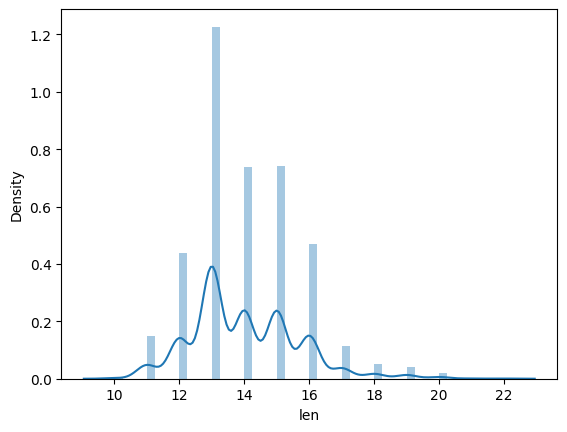

In [22]:
sns.distplot(ismart_res[chain][-ismart_res[chain]['cluster'].isna()]['len'])

In [47]:
chain = 'TRA'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

{'purity': 0.8156190476190476,
 'retention': 0.2178965717606043,
 'consistency': 0.00573968253968254,
 'ami': 0.6004949997025787,
 'accuracy': 0.009473015873015874,
 'precision': 0.8164968669538486,
 'recall': 0.8156190476190475,
 'f1-score': 0.8160577212227047,
 'support': 2625,
 'mean_clustsize': 3.2051282051282053}

In [48]:
chain = 'TRB'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

{'purity': 0.8866517524235645,
 'retention': 0.16661144703056407,
 'consistency': 0.005670519512801392,
 'ami': 0.7804564311637734,
 'accuracy': 0.008417792077854104,
 'precision': 0.8874226799477494,
 'recall': 0.8866517524235645,
 'f1-score': 0.887037048681623,
 'support': 4023,
 'mean_clustsize': 3.3892165122156697}

### Compare metrics

In [86]:
metrics_res = {}

In [87]:
chain = 'TRA'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

chain = 'TRB'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

In [88]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [89]:
print(sns.color_palette("Set2").as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


In [90]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSMART':'#a6d854','TCRemb':'#66c2a5'}

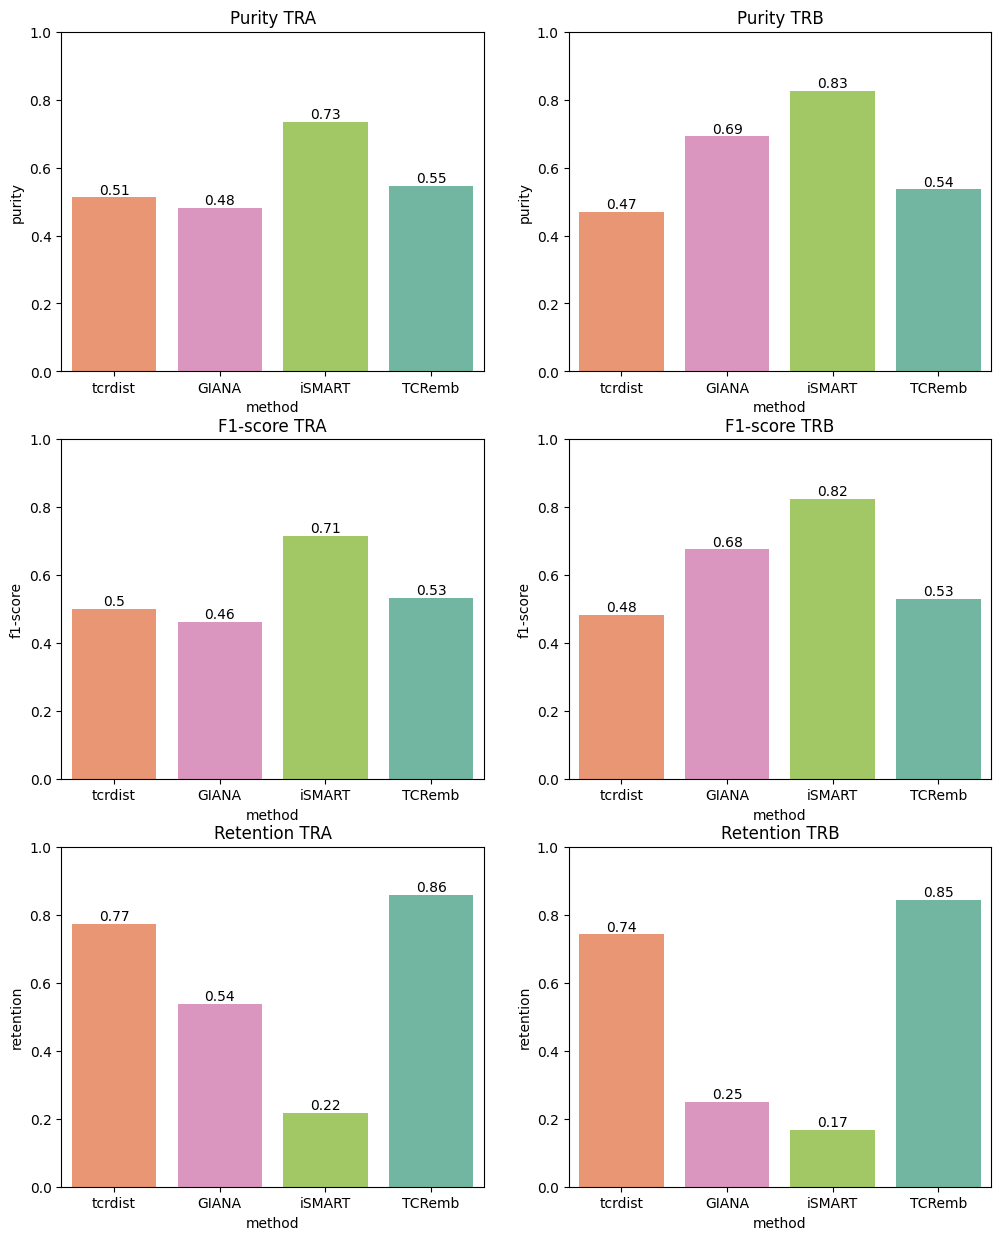

In [91]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [92]:
metrics_res_2 = {}

In [93]:
chain = 'TRA'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

chain = 'TRB'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

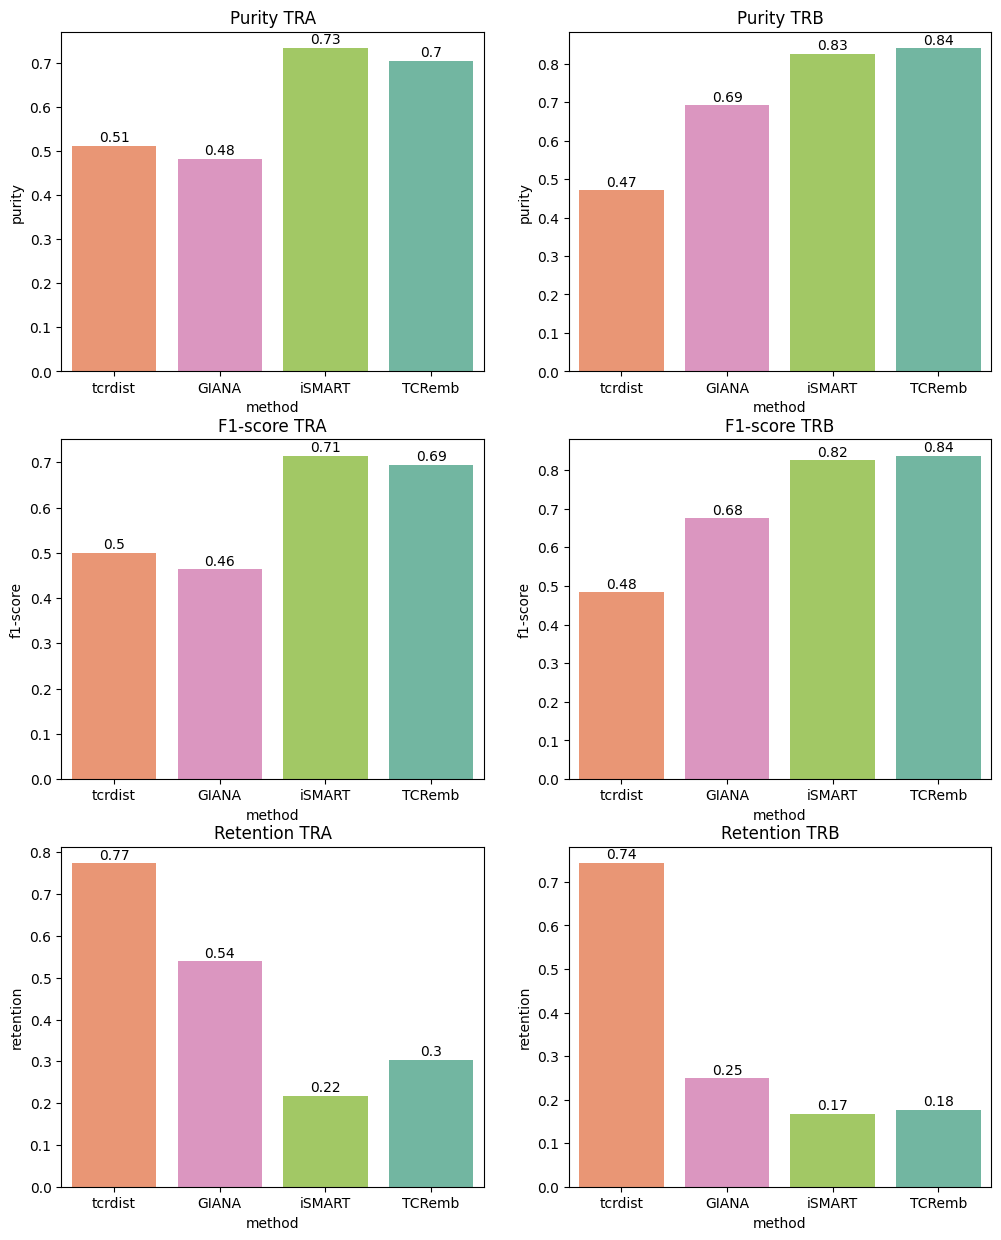

In [94]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 

chain = 'TRB'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   

plt.savefig(f"figures/fig4_2.png")

In [95]:
metrics_3 = {}

In [96]:
chain = 'TRA'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

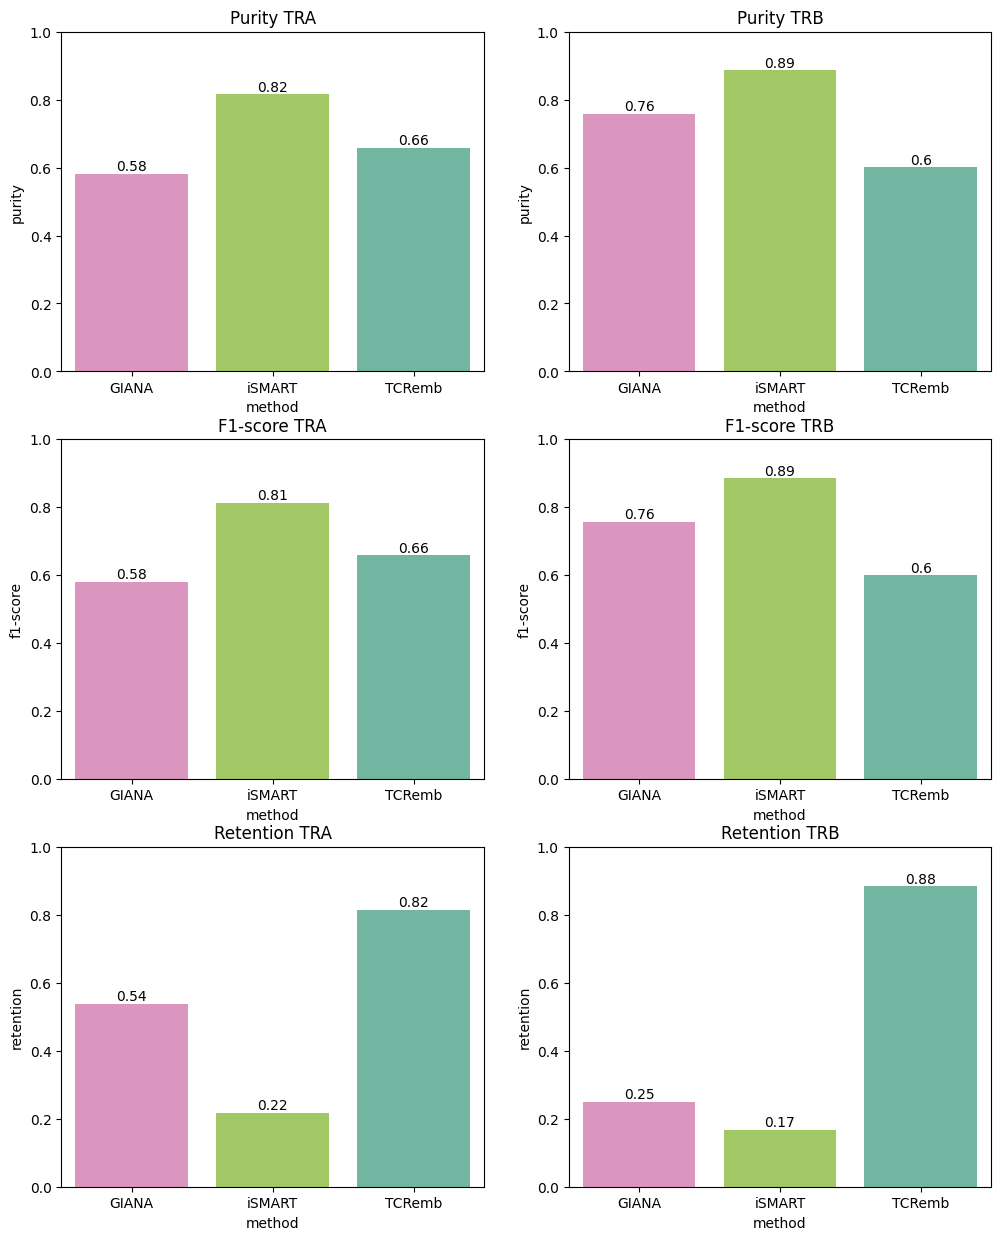

In [97]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

## VDJdb V10-V1000

In [4]:
samples_n = [10,50,100,500,1000]
#samples_n = [1000]

In [5]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3

In [ ]:
chain = 'TRA'
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    vdjdb_v['v'] = vdjdb_v['v'].str.replace('DV','/DV')
    print(len(vdjdb_v))
    
    tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

### ismart

In [22]:
## Run ismart
chain = 'TRA'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10352
Clustering 10352 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.362935
Performing pairwise alignment
Number of pairs to be processed: 589148
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
Done! Time Elapsed 9.720181
Total time elapsed: 13.231635
Maximum memory usage: 0.108412 MB
Elapsed time: 16.383455276489258 seconds.
TCR-epitope paires count in V50 dataset: 9259
Clusterin

In [23]:
## Run ismart
chain = 'TRB'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 22057
Clustering 22057 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 5.840362
Performing pairwise alignment
Number of pairs to be processed: 2565974
Processed 1000000 pairs. Elapsed time 17.206232
Processed 2000000 pairs. Elapsed time 34.571730
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
    Solved 1000 clusters
Done! Time Elapsed 50.620343
Total time ela

In [6]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 10352
{'f1': 0.7989197956940378, 'precision': 0.8066755109473737, 'recall': 0.8028998640688718}
0.8028998640688718


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8028998640688718, 'retention': 0.21319551777434312, 'consistency': 0.0024254377781923824, 'ami': 0.6792427097713462, 'accuracy': 0.001809130194756602, 'precision': 0.8066755109473737, 'recall': 0.8028998640688721, 'f1-score': 0.8047832591633642, 'support': 2207, 'mean_clustsize': 3.2455882352941177, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 9259
{'f1': 0.8298245726810306, 'precision': 0.8380512560994907, 'recall': 0.8292170257488176}
0.8292170257488176
{'purity': 0.8292170257488176, 'retention': 0.20552975483313532, 'consistency': 0.0051234892275354715, 'ami': 0.6875189510586341, 'accuracy': 0.11717455830037425, 'precision': 0.8380512560994906, 'recall': 0.8292170257488176, 'f1-score': 0.8336107362847394, 'support': 1903, 'mean_clustsize': 3.33859649122807, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 8648
{'f1': 0.8487542126536403, 'precision': 0.8510647686295968, 'recall': 0.8504027617951668}
0.8504027617951668
{'purity': 0.85040276179

In [7]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 22057
{'f1': 0.8475415917017777, 'precision': 0.8524283813561937, 'recall': 0.8581750066898581}
0.8581750066898581


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8581750066898581, 'retention': 0.16942467243958834, 'consistency': 0.0014481575343543893, 'ami': 0.8324035243082634, 'accuracy': 0.0034684864894939686, 'precision': 0.8524283813561941, 'recall': 0.8581750066898577, 'f1-score': 0.8552920413756162, 'support': 3737, 'mean_clustsize': 3.4252978918423467, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 19791


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.8684105902348268, 'precision': 0.8713125038692191, 'recall': 0.8725728155339806}
0.8725728155339806
{'purity': 0.8725728155339806, 'retention': 0.16654034662220202, 'consistency': 0.002552396363075975, 'ami': 0.8313900323763072, 'accuracy': 0.0039310115526911115, 'precision': 0.8713125038692193, 'recall': 0.8725728155339804, 'f1-score': 0.8719422042859041, 'support': 3296, 'mean_clustsize': 3.4878306878306877, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 18072
{'f1': 0.8895233708938829, 'precision': 0.8946058743307275, 'recall': 0.8928203366540708}
0.8928203366540708
{'purity': 0.8928203366540708, 'retention': 0.16107791057990262, 'consistency': 0.003914371982859932, 'ami': 0.8446002461907535, 'accuracy': 0.004447409882626944, 'precision': 0.8946058743307276, 'recall': 0.8928203366540707, 'f1-score': 0.8937122136668303, 'support': 2911, 'mean_clustsize': 3.620646766169154, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 11184
{'f1': 0.96380191011

### GIANA

In [49]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10352
GIANA clustering of 10352 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.032364
Maximum memory usage: 0.188212 MB
Elapsed time: 9.464545249938965 seconds.
TCR-epitope paires count in V50 dataset: 9259
GIANA clustering of 9259 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.505859
Maximum memory usage: 0.187800 MB
Elapsed time: 6.696475982666016 seconds.
TCR-epitope paires count in V100 dataset: 8648
GIANA clustering of 8648 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.491158
Maximum memory usage: 0.188364 MB
Elapsed time: 6.345656633377075 seconds.
TCR-epitope paires count in V500 dataset: 5634
GIANA clustering of 5634 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.934739
Maximum memory usage: 0.182540 MB
Elapsed time: 5.853967905044556 seconds.
TCR-epitope paires count in V1000 dataset: 4971
GIANA clustering of 4971 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.851881
Maximum memory usage: 0.180824 MB
Elapsed time: 5.6939496994018555 seconds.


In [50]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 22057
GIANA clustering of 22057 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.305523
Maximum memory usage: 0.211200 MB
Elapsed time: 7.151759624481201 seconds.
TCR-epitope paires count in V50 dataset: 19791
GIANA clustering of 19791 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.939144
Maximum memory usage: 0.208416 MB
Elapsed time: 6.755534648895264 seconds.
TCR-epitope paires count in V100 dataset: 18072
GIANA clustering of 18072 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.714990
Maximum memory usage: 0.209828 MB
Elapsed time: 6.371723175048828 seconds.
TCR-epitope paires count in V500 dataset: 11184
GIANA clustering of 11184 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.206529
Maximum memory usage: 0.194932 MB
Elapsed time: 5.935282468795776 seconds.
TCR-epitope paires count in V1000 dataset: 8763
GIANA clustering of 8763 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.770880
Maximum memory usage: 0.189668 MB
Elapsed time: 5.781248331069946 seconds.


In [8]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 10352
{'f1': 0.5227617295274909, 'precision': 0.5461768198064888, 'recall': 0.548778213019959}
0.548778213019959


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.548778213019959, 'retention': 0.517870942812983, 'consistency': 0.001279420697439724, 'ami': 0.30376688325432744, 'accuracy': 0.001117732818641796, 'precision': 0.5461768198064889, 'recall': 0.5487782130199589, 'f1-score': 0.5474744262193583, 'support': 5361, 'mean_clustsize': 4.9730983302411875, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 9259
{'f1': 0.5722748334298549, 'precision': 0.5886703194692913, 'recall': 0.5859324585932458}
0.5859324585932458
{'purity': 0.5859324585932458, 'retention': 0.5021060589696511, 'consistency': 0.0030574931628921742, 'ami': 0.3129181087615778, 'accuracy': 0.0739096906561874, 'precision': 0.5886703194692914, 'recall': 0.5859324585932458, 'f1-score': 0.5872981982154811, 'support': 4649, 'mean_clustsize': 4.857889237199582, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 8648
{'f1': 0.598793952128795, 'precision': 0.6165793965555366, 'recall': 0.6112925804946336}
0.6112018669778296
{'purity': 0.6112018669778296, 

In [9]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[chain][i] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 22057
{'f1': 0.7193003389680143, 'precision': 0.7249899616436254, 'recall': 0.7337136547662864}
0.7337136547662864


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.7337136547662864, 'retention': 0.24636169923380333, 'consistency': 0.0009573893978156169, 'ami': 0.6366612223330667, 'accuracy': 0.003119239012154961, 'precision': 0.7249899616436257, 'recall': 0.7337136547662855, 'f1-score': 0.7293257224323414, 'support': 5434, 'mean_clustsize': 3.5171521035598707, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 19791
{'f1': 0.7526459916736051, 'precision': 0.7598913887165964, 'recall': 0.7607232968881413}
0.7607232968881413
{'purity': 0.7607232968881413, 'retention': 0.2403112525895609, 'consistency': 0.0021059447047672443, 'ami': 0.6497707226753061, 'accuracy': 0.0033521465692311282, 'precision': 0.7598913887165966, 'recall': 0.7607232968881412, 'f1-score': 0.760307115239393, 'support': 4756, 'mean_clustsize': 3.5334323922734026, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 18072
{'f1': 0.7731527160808344, 'precision': 0.7780485863172668, 'recall': 0.7799476065729936}
0.7799476065729936
{'purity': 0.779947606

### TCRemb

In [11]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True)

TCR-epitope paires count in V10 dataset: 10352
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10 --chain TRA --label antigen.epitope --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
For n_clusters = 51 The average silhouette_score is : 0.14724743330145937
For n_clusters = 102 The average silhouette_score is : 0.13209640422343172
For n_clusters = 508 The average silhouette_score is : 0.15566337601235455
For n_clusters = 1015 The average silhouette_score is : 0.17423991417139756
For n_clusters = 1523 The average silhouette_score is : 0.19277645974209567
For n_clusters = 2031 The average silhouette_score is : 0.20792593046099964
For n_clusters = 2538 The average silhouette_score is : 0.21865460007218923
For n_clusters = 3046 The average silhouette_score is : 0.22303468043040967
For n_clusters = 4061 The average silhouette_score is : 0.22990085115135506
For n_clusters = 5076 The average silhouette_score is : 0.2276734117173486
For n_clusters = 6092 The average silhouette_score is : 0.21477365295343695
For n

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
For n_clusters = 46 The average silhouette_score is : 0.14763610760396
For n_clusters = 91 The average silhouette_score is : 0.13745552903136707
For n_clusters = 456 The average silhouette_score is : 0.15490456455170074
For n_clusters = 911 The average silhouette_score is : 0.1731493775518927
For n_clusters = 1367 The average silhouette_score is : 0.18903230647700947
For n_clusters = 1823 The average silhouette_score is : 0.2009052842899504
For n_clusters = 2278 The average silhouette_score is : 0.21256895541591903
For n_clusters = 2734 The average silhouette_score is : 0.2196734995533929
For n_clusters = 3645 The average silhouette_score is : 0.22940095427414117
For n_clusters = 4556 The average silhouette_score is : 0.22376770087552036
For n_clusters = 5468 The average silhouette_score is : 0.21292341167338383
For n_cluste

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
For n_clusters = 43 The average silhouette_score is : 0.14742847703688883
For n_clusters = 85 The average silhouette_score is : 0.13818934535616895
For n_clusters = 427 The average silhouette_score is : 0.16025213804511193
For n_clusters = 854 The average silhouette_score is : 0.17465031216328408
For n_clusters = 1281 The average silhouette_score is : 0.18653780653069038
For n_clusters = 1707 The average silhouette_score is : 0.19951784693918187
For n_clusters = 2134 The average silhouette_score is : 0.20931117199115015
For n_clusters = 2561 The average silhouette_score is : 0.21999380182222286
For n_clusters = 3415 The average silhouette_score is : 0.22553113014841908
For n_clusters = 4268 The average silhouette_score is : 0.2220728177462969
For n_clusters = 5122 The average silhouette_score is : 0.2107879793075282
For n_c

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
For n_clusters = 28 The average silhouette_score is : 0.17746658233627483
For n_clusters = 56 The average silhouette_score is : 0.14757223405379669
For n_clusters = 280 The average silhouette_score is : 0.15403563079605523
For n_clusters = 560 The average silhouette_score is : 0.16372530666098878
For n_clusters = 841 The average silhouette_score is : 0.18243357673979962
For n_clusters = 1121 The average silhouette_score is : 0.18855210146092596
For n_clusters = 1401 The average silhouette_score is : 0.1956784636535168
For n_clusters = 1682 The average silhouette_score is : 0.20145272051890803
For n_clusters = 2242 The average silhouette_score is : 0.20716291815072446
For n_clusters = 2802 The average silhouette_score is : 0.2050163105582123
For n_clusters = 3363 The average silhouette_score is : 0.19858504012686837
For n_cl

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
For n_clusters = 25 The average silhouette_score is : 0.15767013069110092
For n_clusters = 50 The average silhouette_score is : 0.15022790054549703
For n_clusters = 248 The average silhouette_score is : 0.1481047324117557
For n_clusters = 495 The average silhouette_score is : 0.16159270377131765
For n_clusters = 743 The average silhouette_score is : 0.1767765493574041
For n_clusters = 990 The average silhouette_score is : 0.1845772808019376
For n_clusters = 1238 The average silhouette_score is : 0.19223372908895936
For n_clusters = 1486 The average silhouette_score is : 0.19607504050046132
For n_clusters = 1981 The average silhouette_score is : 0.20408449050218558
For n_clusters = 2476 The average silhouette_score is : 0.20251410068177725
For n_clusters = 2971 The average silhouette_score is : 0.19697676441117717
For n_clu

In [13]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}_dbscan',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 10352
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
purity:0.8024747937671861
Results are in tcremb_outputs/compare_V10_dbscan/
Elapsed time: 91.261474609375 seconds.
TCR-epitope paires count in V50 dataset: 9259
data/data_preped/VDJdb_data_TRA_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V50.csv --runname compare_V50_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
purity:0.831230283911672
Results are in tcremb_outputs/compare_V50_dbscan/
Elapsed time: 78.2089147567749 seconds.
TCR-epitope paires count in V100 dataset: 8648
data/data_preped/VDJdb_data_TRA_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V100.csv --runname compare_V100_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
purity:0.8472934472934472
Results are in tcremb_outputs/compare_V100_dbscan/
Elapsed time: 73.6990008354187 seconds.
TCR-epitope paires count in V500 dataset: 5634
data/data_preped/VDJdb_data_TRA_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V500.csv --runname compare_V500_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
purity:0.9146825396825397
Results are in tcremb_outputs/compare_V500_dbscan/
Elapsed time: 46.777220010757446 seconds.
TCR-epitope paires count in V1000 dataset: 4971
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000_dbscan --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
purity:0.9226519337016574
Results are in tcremb_outputs/compare_V1000_dbscan/
Elapsed time: 41.04651594161987 seconds.


In [ ]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True)

TCR-epitope paires count in V10 dataset: 22057
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
For n_clusters = 109 The average silhouette_score is : 0.09412547913685719
For n_clusters = 217 The average silhouette_score is : 0.09365551932840815
For n_clusters = 1086 The average silhouette_score is : 0.114185562921576
For n_clusters = 2172 The average silhouette_score is : 0.12285180716913625
For n_clusters = 3259 The average silhouette_score is : 0.1322461773634151
For n_clusters = 4345 The average silhouette_score is : 0.1403968133871345
For n_clusters = 5431 The average silhouette_score is : 0.1465950623961835
For n_clusters = 6518 The average silhouette_score is : 0.15182565805919007
For n_clusters = 8690 The average silhouette_score is : 0.154077447898241
For n_clusters = 10862 The average silhouette_score is : 0.15250583196721199
For n_clusters = 13035 The average silhouette_score is : 0.1440746396192383
For n_cl

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
For n_clusters = 98 The average silhouette_score is : 0.09397317913267017
For n_clusters = 195 The average silhouette_score is : 0.09662287011409175
For n_clusters = 976 The average silhouette_score is : 0.11436345649160772
For n_clusters = 1953 The average silhouette_score is : 0.12474632149520554
For n_clusters = 2929 The average silhouette_score is : 0.13214186594539248
For n_clusters = 3905 The average silhouette_score is : 0.14022699774863173
For n_clusters = 4882 The average silhouette_score is : 0.1458760606842427
For n_clusters = 5858 The average silhouette_score is : 0.1515482169884357
For n_clusters = 7810 The average silhouette_score is : 0.15287219529658677
For n_clusters = 9763 The average silhouette_score is : 0.15042871055090887
For n_clusters = 11716 The average silhouette_score is : 0.14367250833860712
For n

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
For n_clusters = 89 The average silhouette_score is : 0.09779568974208412
For n_clusters = 179 The average silhouette_score is : 0.09567157041773812
For n_clusters = 893 The average silhouette_score is : 0.11391870813034032
For n_clusters = 1787 The average silhouette_score is : 0.12618071545963114
For n_clusters = 2680 The average silhouette_score is : 0.1324221503352161
For n_clusters = 3574 The average silhouette_score is : 0.13941029202110752
For n_clusters = 4467 The average silhouette_score is : 0.14599693094279068
For n_clusters = 5360 The average silhouette_score is : 0.15109666968427657
For n_clusters = 7147 The average silhouette_score is : 0.1535981015724466
For n_clusters = 8934 The average silhouette_score is : 0.15109770927862726
For n_clusters = 10721 The average silhouette_score is : 0.1434756271592483
For n

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
For n_clusters = 56 The average silhouette_score is : 0.1080083722709924
For n_clusters = 111 The average silhouette_score is : 0.10279659907481468
For n_clusters = 557 The average silhouette_score is : 0.11815545790131501
For n_clusters = 1114 The average silhouette_score is : 0.12297267430597449
For n_clusters = 1672 The average silhouette_score is : 0.12830174359955718
For n_clusters = 2229 The average silhouette_score is : 0.13657095585825973
For n_clusters = 2786 The average silhouette_score is : 0.14353493496625608
For n_clusters = 3343 The average silhouette_score is : 0.14639718420497114
For n_clusters = 4458 The average silhouette_score is : 0.14958097584525235
For n_clusters = 5572 The average silhouette_score is : 0.14621899586558826
For n_clusters = 6686 The average silhouette_score is : 0.13800525535379726
For 

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [14]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}_dbscan',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 22057
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
purity:0.8986608758595729
Results are in tcremb_outputs/compare_V10_dbscan/
Elapsed time: 209.66479682922363 seconds.
TCR-epitope paires count in V50 dataset: 19791
data/data_preped/VDJdb_data_TRB_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V50.csv --runname compare_V50_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
purity:0.9135504624045034
Results are in tcremb_outputs/compare_V50_dbscan/
Elapsed time: 186.00359678268433 seconds.
TCR-epitope paires count in V100 dataset: 18072
data/data_preped/VDJdb_data_TRB_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V100.csv --runname compare_V100_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
purity:0.9210758377425045
Results are in tcremb_outputs/compare_V100_dbscan/
Elapsed time: 168.41421937942505 seconds.
TCR-epitope paires count in V500 dataset: 11184
data/data_preped/VDJdb_data_TRB_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V500.csv --runname compare_V500_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
purity:0.9601063829787234
Results are in tcremb_outputs/compare_V500_dbscan/
Elapsed time: 98.33077502250671 seconds.
TCR-epitope paires count in V1000 dataset: 8763
data/data_preped/VDJdb_data_TRB_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V1000.csv --runname compare_V1000_dbscan --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
purity:0.968421052631579
Results are in tcremb_outputs/compare_V1000_dbscan/
Elapsed time: 75.2978937625885 seconds.


In [15]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
metrics_tcremb_v_all_clstr[chain]={}
metrics_tcremb_v_enriched[chain] = {}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i = tcremb_res_v[chain][i].copy()
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
    
    metrics_tcremb_v_all_clstr[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_all_clstr[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i.apply(lambda x: 1 if (x['total_cluster']>1) & (x['fraction_matched']>=0.7) else 0,axis=1)
    metrics_tcremb_v_enriched[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_enriched[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 10341
{'f1': 0.6807346016595247, 'precision': 0.6849985639557399, 'recall': 0.6862005608741901}
0.7401041666666667
{'purity': 0.7401041666666667, 'retention': 0.18566869741804468, 'consistency': 0.0018835616438356165, 'ami': 0.5880820942303202, 'accuracy': 0.0005205620659722223, 'precision': 0.7335337329765877, 'recall': 0.7401041666666668, 'f1-score': 0.7368043021938462, 'support': 1920, 'mean_clustsize': 3.2432432432432434, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9249
{'f1': 0.6790103760476489, 'precision': 0.680743679018854, 'recall': 0.6845064331279057}
0.7578125
{'purity': 0.7578125, 'retention': 0.26294734565899014, 'consistency': 0.003230733082706766, 'ami': 0.561441480381192, 'accuracy': 0.08593073710180055, 'precision': 0.7580973292708784, 'recall': 0.7578124999999999, 'f1-score': 0.757954887876686, 'support': 2432, 'mean_clustsize': 3.545189504373178, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 86

In [10]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v_dbscan[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}_dbscan/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v_dbscan[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v_dbscan[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v_dbscan[chain][i])

TCR-epitope paires count in V10 dataset: 10341


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.32792987516115474, 'precision': 0.6620324091089255, 'recall': 0.3720143119620926}
0.8024747937671861
{'purity': 0.8024747937671861, 'retention': 0.21100473841988202, 'consistency': 0.002207562515330295, 'ami': 0.6703228538427611, 'accuracy': 0.0018281397417920643, 'precision': 0.8069971767646765, 'recall': 0.8024747937671864, 'f1-score': 0.8047296316455049, 'support': 2182, 'mean_clustsize': 3.190058479532164, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9249
{'f1': 0.3509235526584758, 'precision': 0.6905017505267138, 'recall': 0.39993512812195914}
0.831230283911672


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.831230283911672, 'retention': 0.20564385338955563, 'consistency': 0.004525311701967854, 'ami': 0.6841668734053117, 'accuracy': 0.12518340868707578, 'precision': 0.8310695009402953, 'recall': 0.8312302839116719, 'f1-score': 0.831149884650261, 'support': 1902, 'mean_clustsize': 3.256849315068493, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 8638
{'f1': 0.3661512830027966, 'precision': 0.7066760134647871, 'recall': 0.41838388515860153}
0.8472934472934472
{'purity': 0.8472934472934472, 'retention': 0.20317203056263025, 'consistency': 0.006987554355975408, 'ami': 0.6850600028974452, 'accuracy': 0.13451319388641328, 'precision': 0.8460871590682165, 'recall': 0.8472934472934471, 'f1-score': 0.8466898735280777, 'support': 1755, 'mean_clustsize': 3.2681564245810057, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 5626
{'f1': 0.4847838824924788, 'precision': 0.7579497767478607, 'recall': 0.5494134376110914}
0.9146825396825397
{'purity': 0.9146825396825

In [17]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
metrics_tcremb_v_all_clstr[chain]={}
metrics_tcremb_v_enriched[chain] = {}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i = tcremb_res_v[chain][i].copy()
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
    
    metrics_tcremb_v_all_clstr[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_all_clstr[chain][i]['method']='TCRemb'
    
    tcremb_res_v_i['is_cluster']=tcremb_res_v_i.apply(lambda x: 1 if (x['total_cluster']>1) & (x['fraction_matched']>=0.7) else 0,axis=1)
    metrics_tcremb_v_enriched[chain][i] = metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')
    metrics_tcremb_v_enriched[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 22038
{'f1': 0.5984780034315138, 'precision': 0.6029530733852388, 'recall': 0.604546692077321}
0.7749135491983653
{'purity': 0.7749135491983653, 'retention': 0.14434159179598874, 'consistency': 0.0010302962158986867, 'ami': 0.6674840609929528, 'accuracy': 0.004694744741969892, 'precision': 0.7606616602764501, 'recall': 0.774913549198366, 'f1-score': 0.7677214678472742, 'support': 3181, 'mean_clustsize': 3.8004778972520907, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19774
{'f1': 0.652763733665317, 'precision': 0.658848433268093, 'recall': 0.6542935167391524}
0.7900425810678021
{'purity': 0.7900425810678021, 'retention': 0.15439465965409124, 'consistency': 0.0015493477661836655, 'ami': 0.6686217801580784, 'accuracy': 0.004893888502596717, 'precision': 0.8005092260656238, 'recall': 0.7900425810678026, 'f1-score': 0.7952414656260504, 'support': 3053, 'mean_clustsize': 3.6694711538461537, 'method': 'TCRemb'}
TCR-epitope paires count

In [11]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v_dbscan[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}_dbscan/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v_dbscan[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v_dbscan[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v_dbscan[chain][i])

TCR-epitope paires count in V10 dataset: 22038


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.24228734840638136, 'precision': 0.6835307454513687, 'recall': 0.3099192304201833}
0.8986608758595729
{'purity': 0.8986608758595729, 'retention': 0.1253743533895998, 'consistency': 0.0012826637712631199, 'ami': 0.8510495368117647, 'accuracy': 0.003968211864316863, 'precision': 0.8989282251793431, 'recall': 0.8986608758595731, 'f1-score': 0.8987945306384801, 'support': 2763, 'mean_clustsize': 3.216530849825378, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19774


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.26208044324311636, 'precision': 0.7233616083747617, 'recall': 0.3350864771922727}
0.9135504624045034
{'purity': 0.9135504624045034, 'retention': 0.12577121472640843, 'consistency': 0.0019066889762247557, 'ami': 0.8555791772677905, 'accuracy': 0.004406993568001133, 'precision': 0.9152285387822379, 'recall': 0.9135504624045031, 'f1-score': 0.9143887306970825, 'support': 2487, 'mean_clustsize': 3.2723684210526316, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 18056


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.27947475119450765, 'precision': 0.7138595522705284, 'recall': 0.35727735932653965}
0.9210758377425045
{'purity': 0.9210758377425045, 'retention': 0.1256092157731502, 'consistency': 0.002668708809059686, 'ami': 0.8541462521081847, 'accuracy': 0.004830841801741272, 'precision': 0.9196972828047397, 'recall': 0.9210758377425046, 'f1-score': 0.9203860440737452, 'support': 2268, 'mean_clustsize': 3.350073855243722, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 11170
{'f1': 0.4377714759029794, 'precision': 0.7308563467255317, 'recall': 0.5228290062667861}
0.9601063829787234
{'purity': 0.9601063829787234, 'retention': 0.13464637421665174, 'consistency': 0.012743794326241136, 'ami': 0.8567429492262921, 'accuracy': 0.1809125134393391, 'precision': 0.9603427033174594, 'recall': 0.9601063829787235, 'f1-score': 0.960224528607924, 'support': 1504, 'mean_clustsize': 3.7506234413965087, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 8749
{'f1': 0.53272551561212

In [45]:
tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['total_cluster']==3].sort_values('total_cluster')#.drop_duplicates('antigen.epitope')

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,j,chain,cloneId,clone_size,data_id,antigen.epitope,DM1,DM2,DM1_clones,DM2_clones
10259,3632,10268,NLVPMVATV,3,2375,2,0.666667,0.229668,0.134014,0,...,TRAJ22,TRA,495,1,74667,DPFRLLQNSQVFS,41.086433,-53.812325,36.633312,-51.469110
10262,2077,10272,NLVPMVATV,3,2375,1,0.333333,0.229668,0.542877,1,...,TRAJ9,TRA,1387,1,74683,YLQPRTFLL,105.945490,-8.207134,104.203550,-6.943288
10270,2182,10280,TTDPSFLGRY,3,377,1,0.333333,0.036457,0.105432,0,...,TRAJ6,TRA,9362,1,74743,KLSALGINAV,9.714216,84.786150,6.794478,79.855350
10274,2755,10284,SPRWYFYYL,3,380,1,0.333333,0.036747,0.106239,1,...,TRAJ34,TRA,5661,1,74764,SPRWYFYYL,-27.537905,32.323430,-29.218740,27.469984
10276,2972,10286,NLVPMVATV,3,2375,2,0.666667,0.229668,0.134014,0,...,TRAJ26,TRA,64,1,74804,NLVPMVATV,-24.743185,80.235170,-19.007078,73.737380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10318,1170,10329,GILGFVFTL,3,2589,3,1.000000,0.250363,0.015693,1,...,TRAJ54,TRA,4528,1,75127,GILGFVFTL,-7.250823,-11.317201,-5.565074,-14.958485
10334,4031,10345,GPRLGVRAT,3,47,1,0.333333,0.004545,0.013573,0,...,TRAJ6,TRA,7103,1,75226,NLVPMVATV,-28.058624,9.727301,-33.594723,3.727268
10336,1848,10347,CINGVCWTV,3,225,1,0.333333,0.021758,0.063864,1,...,TRAJ37,TRA,1538,1,75229,CINGVCWTV,70.864710,-22.082079,68.015570,-22.416403
10339,1472,10350,GLIYNRMGAVTTEV,3,119,2,0.666667,0.011508,0.000394,1,...,TRAJ34,TRA,8222,1,75257,TTDPSFLGRY,-64.279976,-19.912079,-79.101080,-37.804510


In [49]:
tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['cluster'].isin([3632,2182])]

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,j,chain,cloneId,clone_size,data_id,antigen.epitope,DM1,DM2,DM1_clones,DM2_clones
3321,2182,3230,TTDPSFLGRY,3,377,1,0.333333,0.036457,0.105432,0,...,TRAJ33,TRA,9211,1,23903,TTDPSFLGRY,9.359827,84.590090,6.512526,79.644600
5155,2182,5075,TTDPSFLGRY,3,377,1,0.333333,0.036457,0.105432,0,...,TRAJ33,TRA,9895,1,37305,GILGFVFTL,9.278052,84.563370,6.446994,79.624870
6063,3632,5984,NLVPMVATV,3,2375,2,0.666667,0.229668,0.134014,0,...,TRAJ22,TRA,668,1,43800,NLVPMVATV,41.006110,-53.918247,36.703730,-51.549137
7895,3632,7838,NLVPMVATV,3,2375,2,0.666667,0.229668,0.134014,0,...,TRAJ22,TRA,877,1,57240,NLVPMVATV,41.609800,-53.812294,36.098310,-51.373917
10259,3632,10268,NLVPMVATV,3,2375,2,0.666667,0.229668,0.134014,0,...,TRAJ22,TRA,495,1,74667,DPFRLLQNSQVFS,41.086433,-53.812325,36.633312,-51.469110
10270,2182,10280,TTDPSFLGRY,3,377,1,0.333333,0.036457,0.105432,0,...,TRAJ6,TRA,9362,1,74743,KLSALGINAV,9.714216,84.786150,6.794478,79.855350


In [51]:
t = tcremb_res_v['TRA'][10][tcremb_res_v['TRA'][10]['cluster'].isin([3632,2182])]
t['is_cluster']=1
metrics.get_clustermetrics(t,'antigen.epitope')

/scratch/ipykernel_787509/1638990362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['is_cluster']=1


{'purity': 0.5,
 'retention': 1.0,
 'consistency': 0.19999999999999998,
 'ami': 0.24218511509616353,
 'accuracy': 0.1111111111111111,
 'precision': 0.2777777777777778,
 'recall': 0.5,
 'f1-score': 0.35714285714285715,
 'support': 6,
 'mean_clustsize': 3.0}

In [52]:
print(recall_score(t['antigen.epitope'],t['label_cluster'],average='weighted'))

0.5


In [21]:
metrics.get_clustermetrics(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])],'antigen.epitope')

{'purity': 0.975,
 'retention': 1.0,
 'consistency': 0.4875,
 'ami': 0.8530115842763767,
 'accuracy': 0.46312499999999995,
 'precision': 0.9762500000000001,
 'recall': 0.975,
 'f1-score': 0.9756245996156311,
 'support': 40,
 'mean_clustsize': 20.0}

In [37]:
t = tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]

In [42]:
from sklearn.metrics import f1_score, recall_score
print(f1_score(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['antigen.epitope'],tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['label_cluster'], average='weighted'))
print(recall_score(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['antigen.epitope'],tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])]['label_cluster'], average='weighted'))



0.9750156347717323
0.975


In [26]:
get_clustermetrics(tcremb_res_v['TRA'][1000][tcremb_res_v['TRA'][1000]['cluster'].isin([330,94])],'antigen.epitope')

GILGFVFTL
NLVPMVATV
[21, 19]


{'purity': 0.975,
 'retention': 1.0,
 'consistency': 0.4875,
 'ami': 0.8530115842763767,
 'accuracy': 0.46312499999999995,
 'precision': 0.9762500000000001,
 'recall': 0.975,
 'f1-score': 0.9756245996156311,
 'support': 40,
 'mean_clustsize': 20.0}

In [8]:
metrics.get_clustermetrics(tcremb_res_v['TRA'][1000], 'antigen.epitope')

{'purity': 0.8460661345496009,
 'retention': 0.3533440773569702,
 'consistency': 0.01111744583808438,
 'ami': 0.3633777033728728,
 'accuracy': 0.3318663059122722,
 'precision': 0.845265593243255,
 'recall': 0.8460661345496009,
 'f1-score': 0.8456656744402815,
 'support': 1754,
 'mean_clustsize': 3.224264705882353}

In [14]:
metrics.get_clustermetrics(tcremb_res_v_all['TRA'][1000], 'antigen.epitope')

NameError: name 'tcremb_res_v_all' is not defined

In [17]:
tcremb_res_v_i = tcremb_res_v['TRA'][10].copy()
tcremb_res_v_i['is_cluster']=tcremb_res_v_i['total_cluster'].apply(lambda x: 1 if x >1 else 0)
metrics.get_clustermetrics(tcremb_res_v_i, 'antigen.epitope')

{'purity': 0.6133682830930537,
 'retention': 0.8116236340779421,
 'consistency': 0.0005529638557161492,
 'ami': 0.3991756260811316,
 'accuracy': 0.000833034637963822,
 'precision': 0.6071853212735059,
 'recall': 0.6133682830930537,
 'f1-score': 0.6102611416597578,
 'support': 8393,
 'mean_clustsize': 3.331877729257642}

In [15]:
t = tcremb_res_v['TRA'][1000]
t_c = t[t['total_cluster']>1]

In [19]:
t = tcremb_res_v['TRA'][1000]
t_c = t[t['is_cluster']==1]

In [20]:
sum(t_c['count_matched'])/sum(t_c['total_cluster'])

0.9017248722316865

In [27]:
from sklearn.metrics import f1_score, recall_score
print(f1_score(t_c['antigen.epitope'],t_c['label_cluster'], average='weighted'))
print(recall_score(t_c['antigen.epitope'],t_c['label_cluster'], average='weighted'))

0.845371731714962
0.8460661345496009


In [28]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [29]:
purity_score(t_c['antigen.epitope'],t_c['label_cluster'])

0.8460661345496009

In [25]:
t_clusters = t[['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','is_cluster']].drop_duplicates()

In [26]:
sum(t_clusters[t_clusters['is_cluster']==1]['count_matched'])/sum(t_clusters[t_clusters['is_cluster']==1]['total_cluster'])

0.8460661345496009

In [147]:
sum(t['total_cluster'])

20184

In [155]:
pd.DataFrame(metrics_tcremb_v['TRA'])

,10,50,100,500,1000
purity,0.740104,0.757812,0.748697,0.871838,0.846066
retention,0.185669,0.262947,0.333063,0.210807,0.353344
consistency,0.001884,0.003231,0.003769,0.019112,0.011117
ami,0.588082,0.561441,0.536589,0.562051,0.363378
accuracy,0.000521,0.085931,0.09336,0.160191,0.331866
precision,0.733534,0.758097,0.752335,0.875694,0.845266
recall,0.740104,0.757812,0.748697,0.871838,0.846066
f1-score,0.736804,0.757955,0.750511,0.873762,0.845666
support,1920,2432,2877,1186,1754
mean_clustsize,3.243243,3.54519,3.478839,3.615854,3.224265


In [18]:
pd.DataFrame(metrics_tcremb_v_all_clstr['TRA'])

,10,50,100,500,1000
purity,0.613368,0.630493,0.660134,0.761725,0.794745
retention,0.811624,0.853822,0.809331,0.848916,0.858783
consistency,0.000553,0.001122,0.001619,0.004746,0.004574
ami,0.399176,0.376824,0.398992,0.318032,0.266124
accuracy,0.000833,0.069587,0.076045,0.114142,0.373603
precision,0.607185,0.622806,0.660453,0.763861,0.79462
recall,0.613368,0.630493,0.660134,0.761725,0.794745
f1-score,0.610261,0.626626,0.660294,0.762792,0.794683
support,8393,7897,6991,4776,4263
mean_clustsize,3.331878,3.44396,3.31327,3.431034,3.330469


### compare

In [12]:
metrics_v = {}

In [13]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [112]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_all_clstr[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_all_clstr[chain]).T])

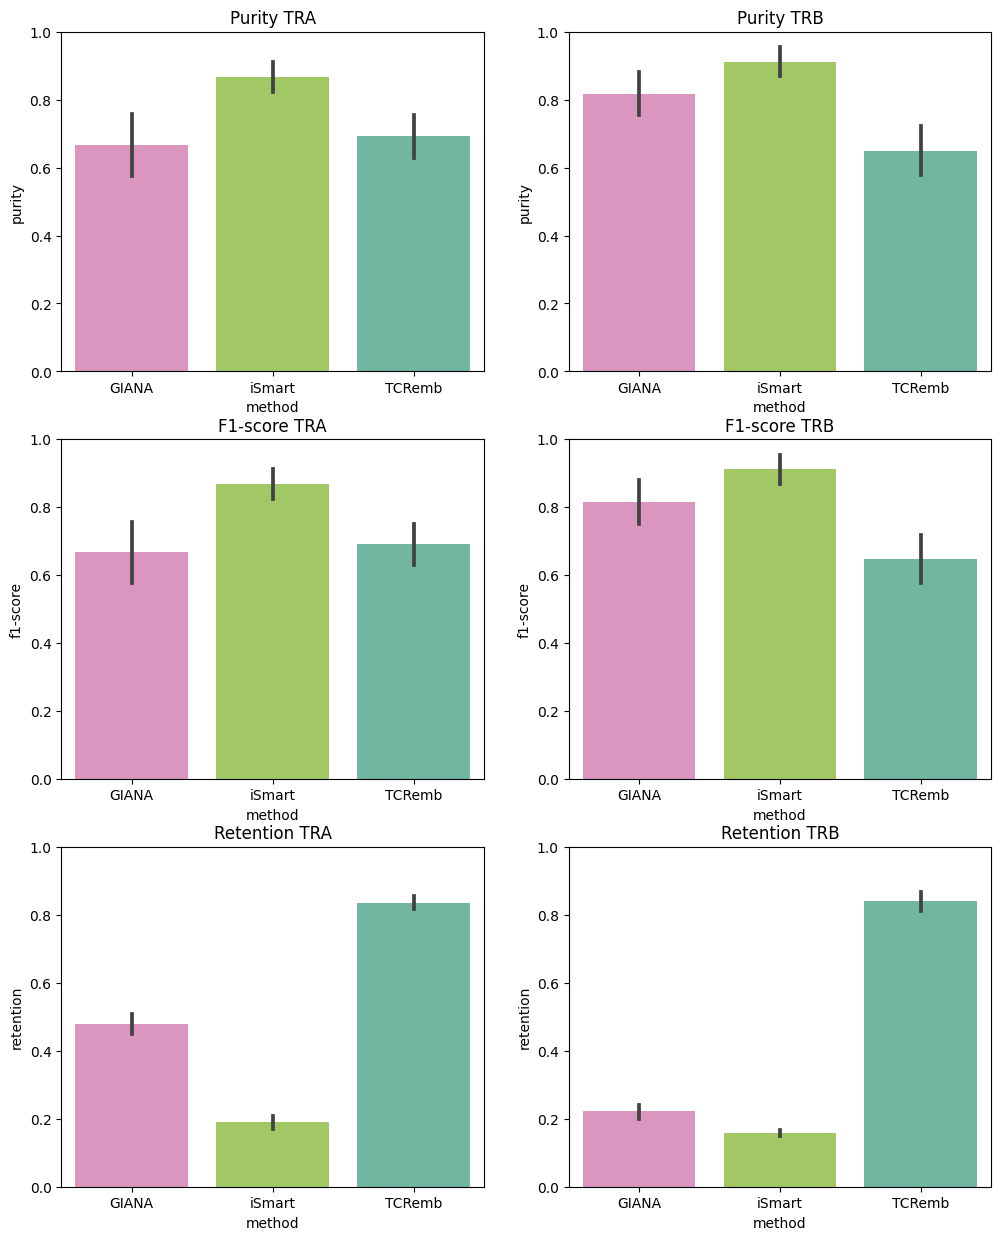

In [113]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [20]:
metrics_v={}

In [21]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_dbscan[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_dbscan[chain]).T])

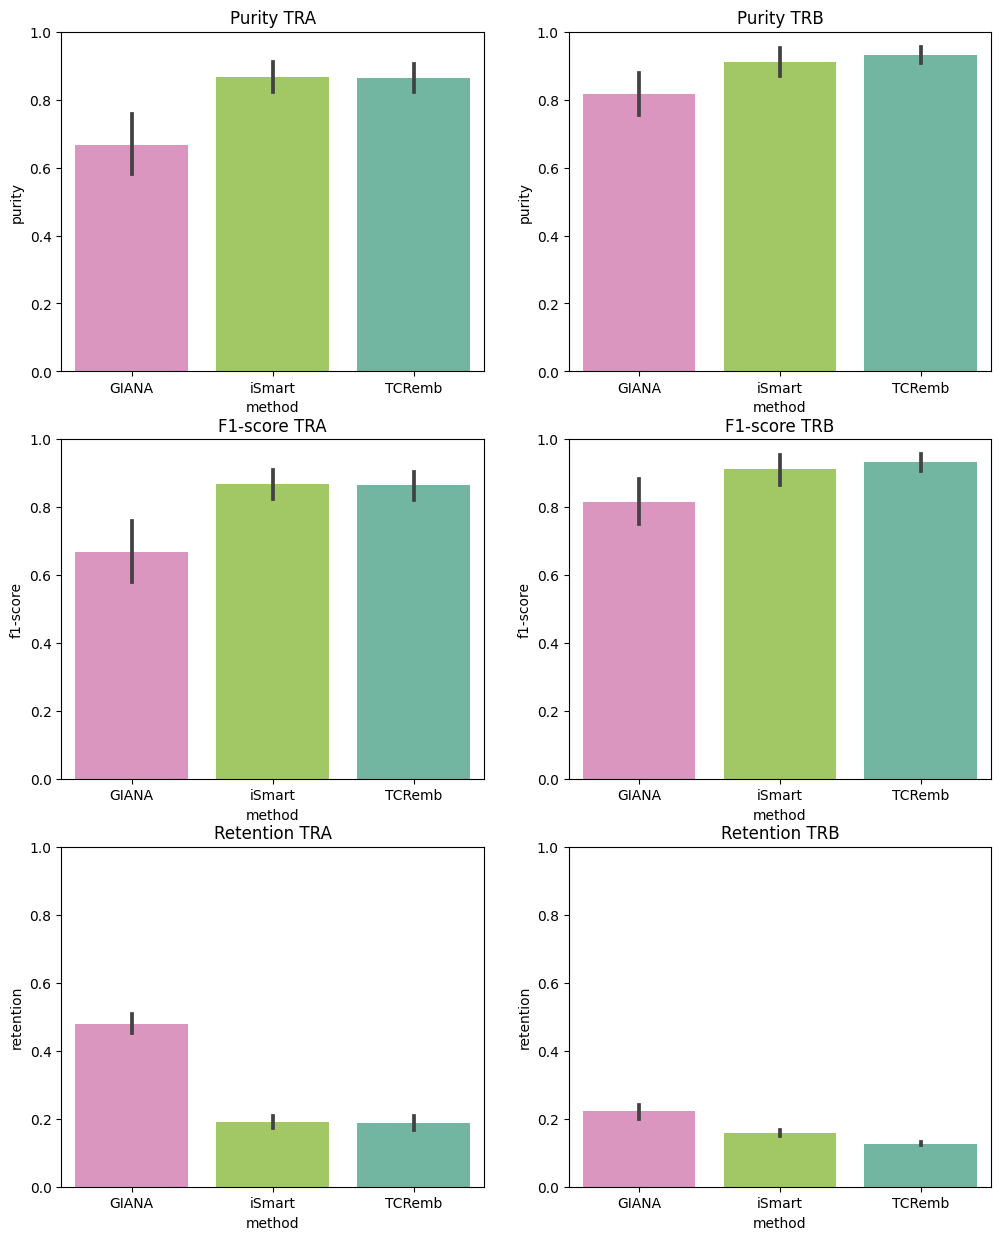

In [15]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_2_2.png")

In [22]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

In [33]:
metrics_v['TRA']

,v_subset,purity,retention,consistency,ami,accuracy,precision,recall,f1-score,support,mean_clustsize,method
0,10,0.548778,0.517871,0.001279,0.303767,0.001118,0.546177,0.548778,0.547474,5361,4.973098,GIANA
1,50,0.585932,0.502106,0.003057,0.312918,0.07391,0.58867,0.585932,0.587298,4649,4.857889,GIANA
2,100,0.611202,0.49549,0.004471,0.318056,0.079048,0.616468,0.611202,0.613823,4285,4.830891,GIANA
3,500,0.775276,0.449414,0.026593,0.339801,0.122208,0.779942,0.775276,0.777602,2532,4.521429,GIANA
4,1000,0.811277,0.431704,0.042171,0.281407,0.316421,0.809811,0.811277,0.810543,2146,4.470833,GIANA
5,10,0.8029,0.213196,0.002425,0.679243,0.001809,0.806676,0.8029,0.804783,2207,3.245588,iSmart
6,50,0.829217,0.20553,0.005123,0.687519,0.117175,0.838051,0.829217,0.833611,1903,3.338596,iSmart
7,100,0.850403,0.200971,0.007419,0.695235,0.125429,0.851065,0.850403,0.850734,1738,3.42126,iSmart
8,500,0.920118,0.179979,0.033531,0.673816,0.204466,0.919444,0.920118,0.919781,1014,3.66065,iSmart
9,1000,0.93068,0.156709,0.050064,0.564936,0.213853,0.932792,0.93068,0.931735,779,3.573394,iSmart


In [41]:
ax_n

5

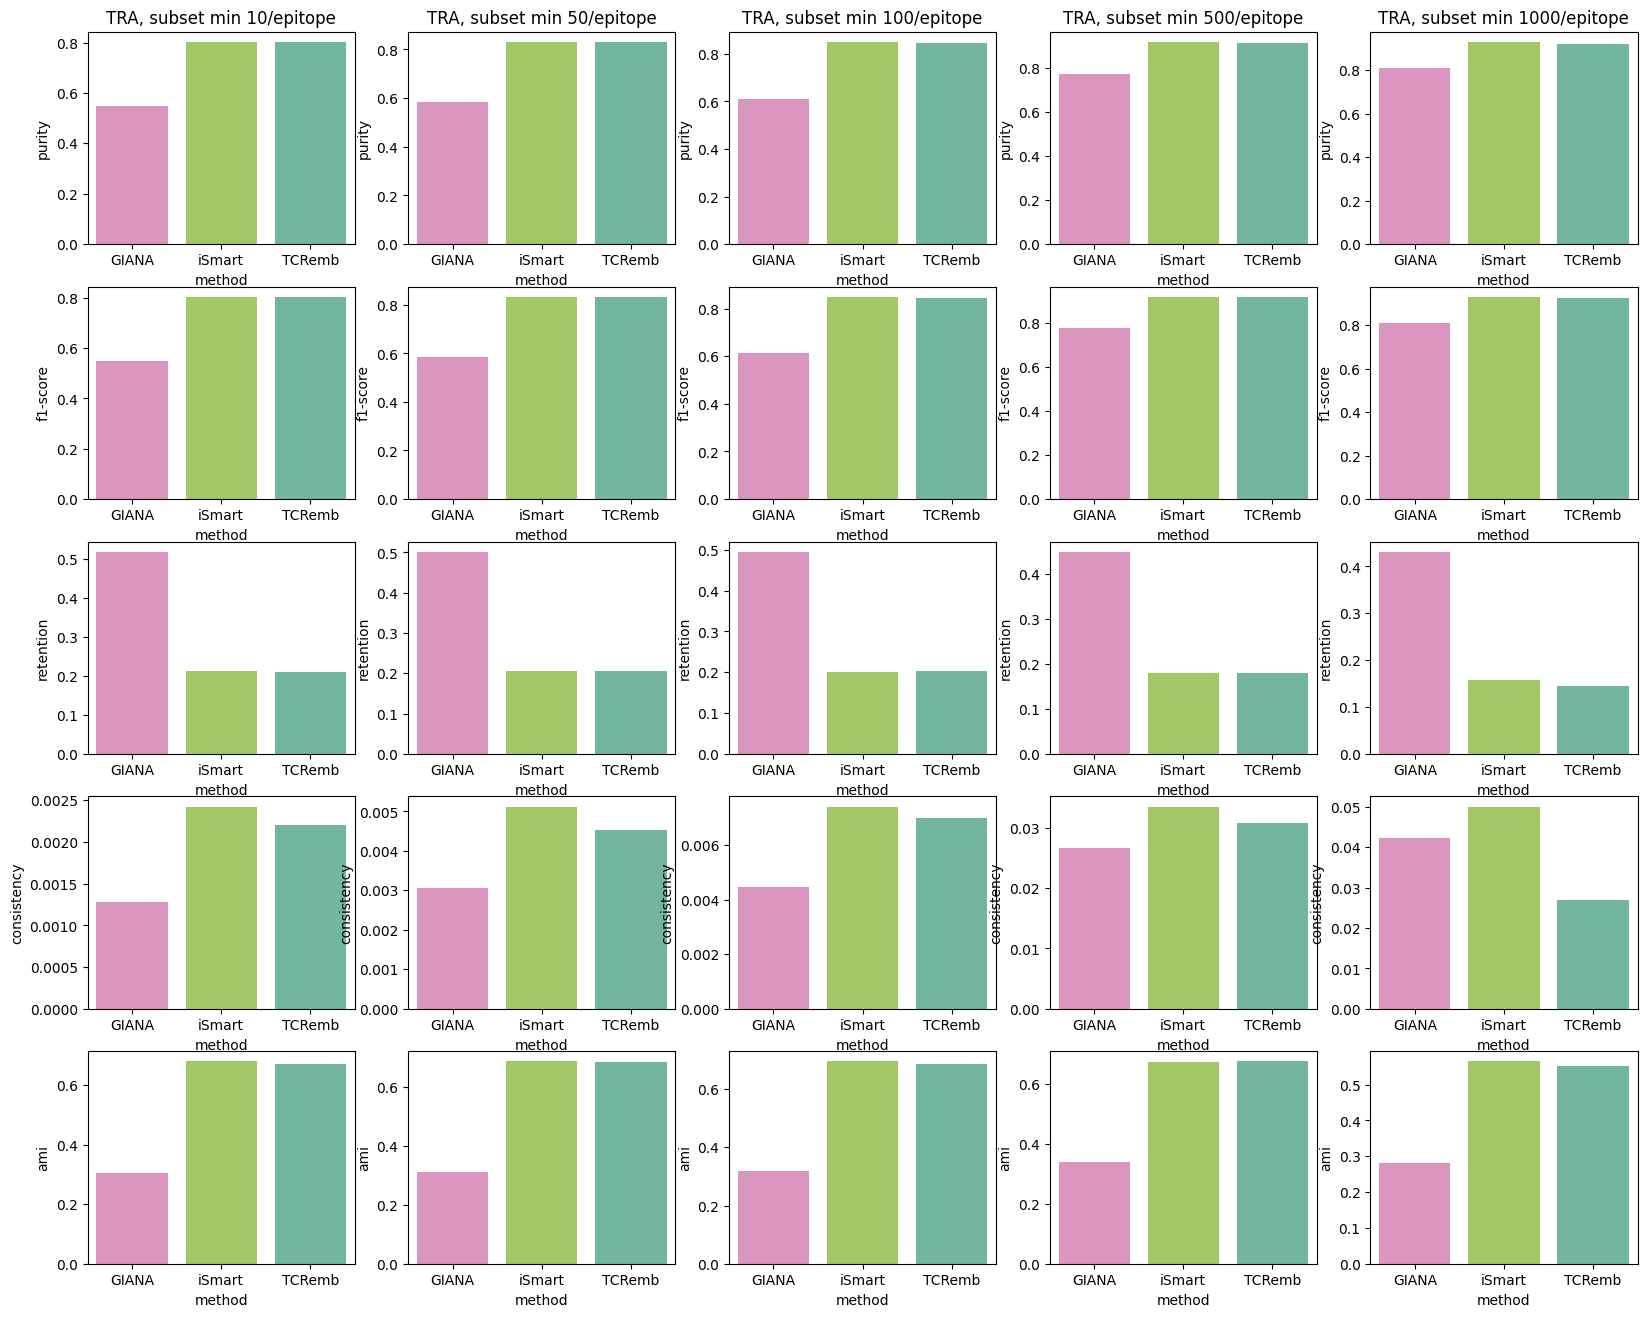

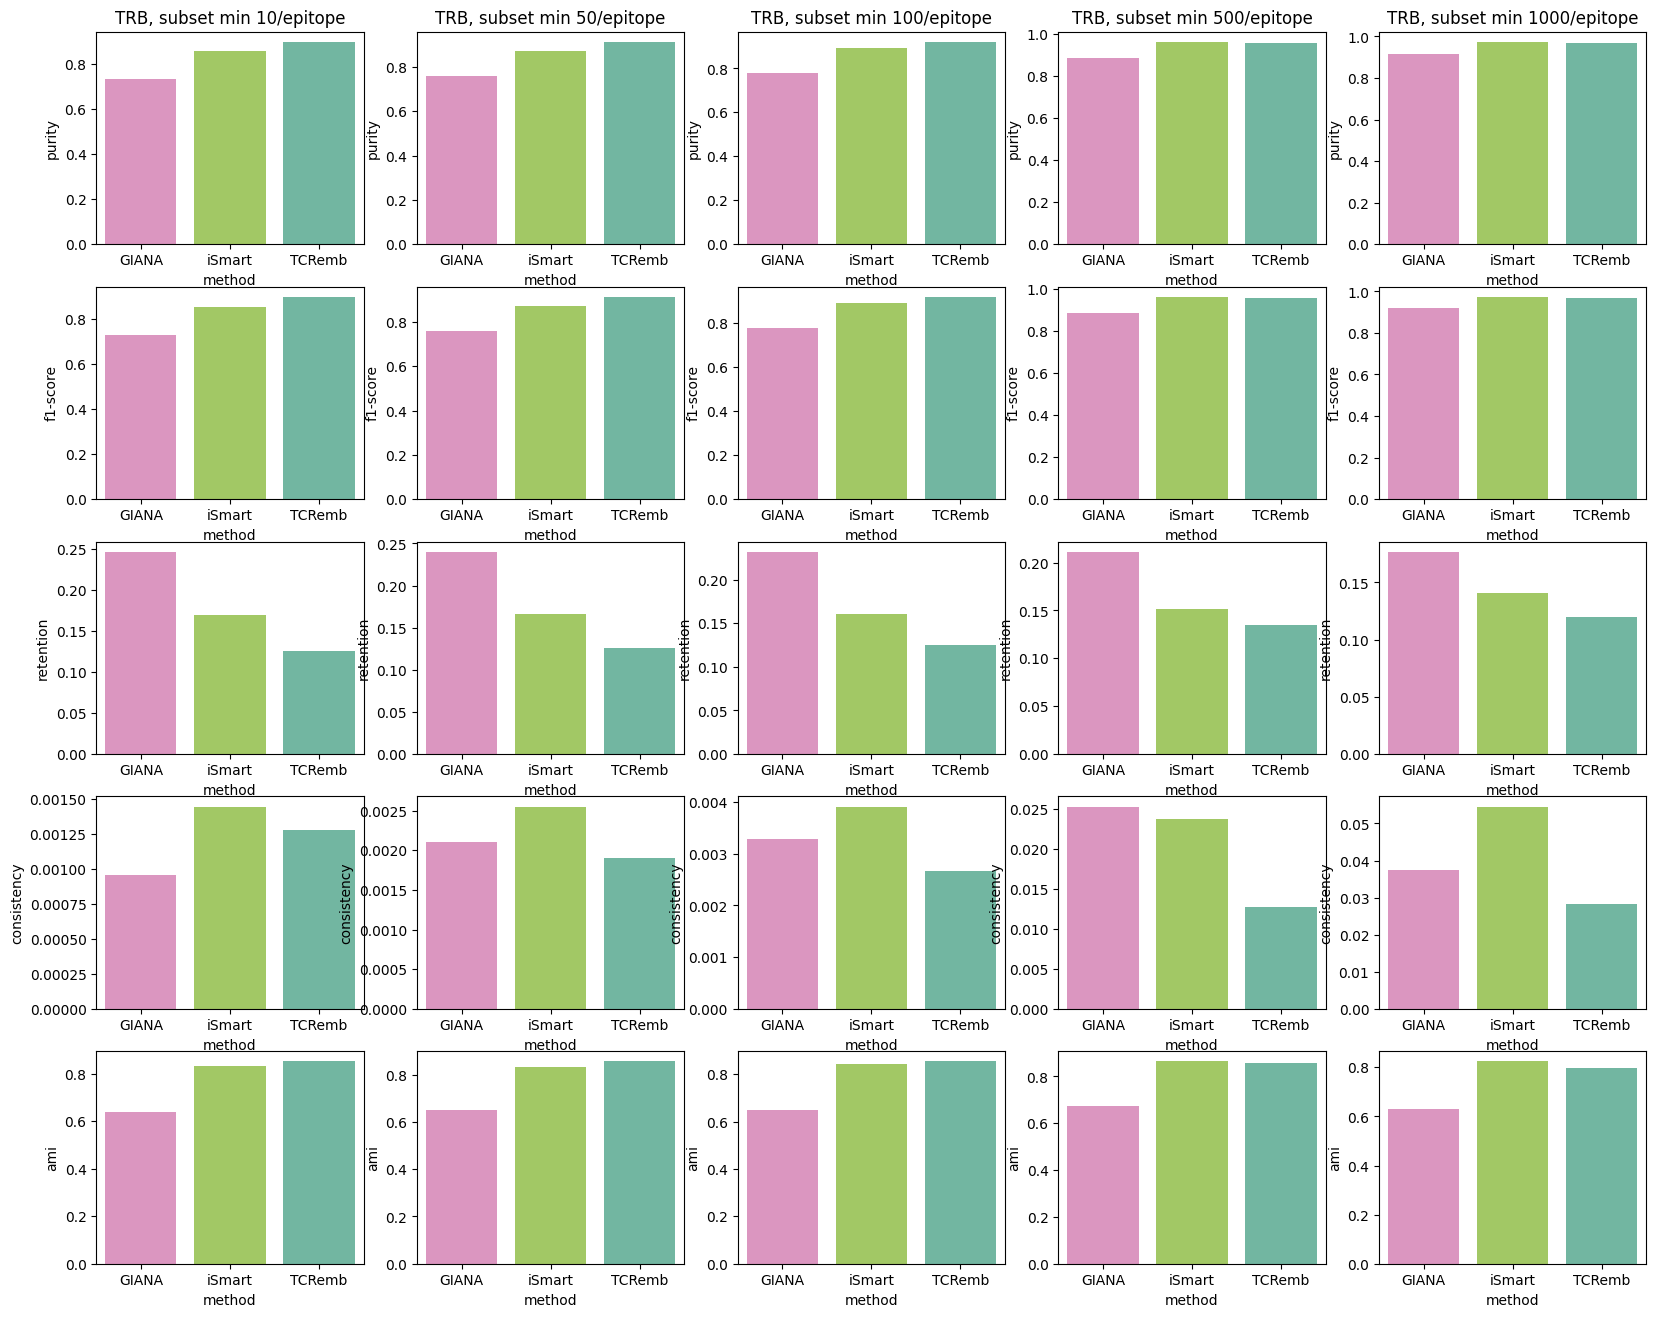

In [51]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,16))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1
plt.savefig(f"figures/fig5_1.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (20,16))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1
plt.savefig(f"figures/fig5_2.png")

In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [133]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

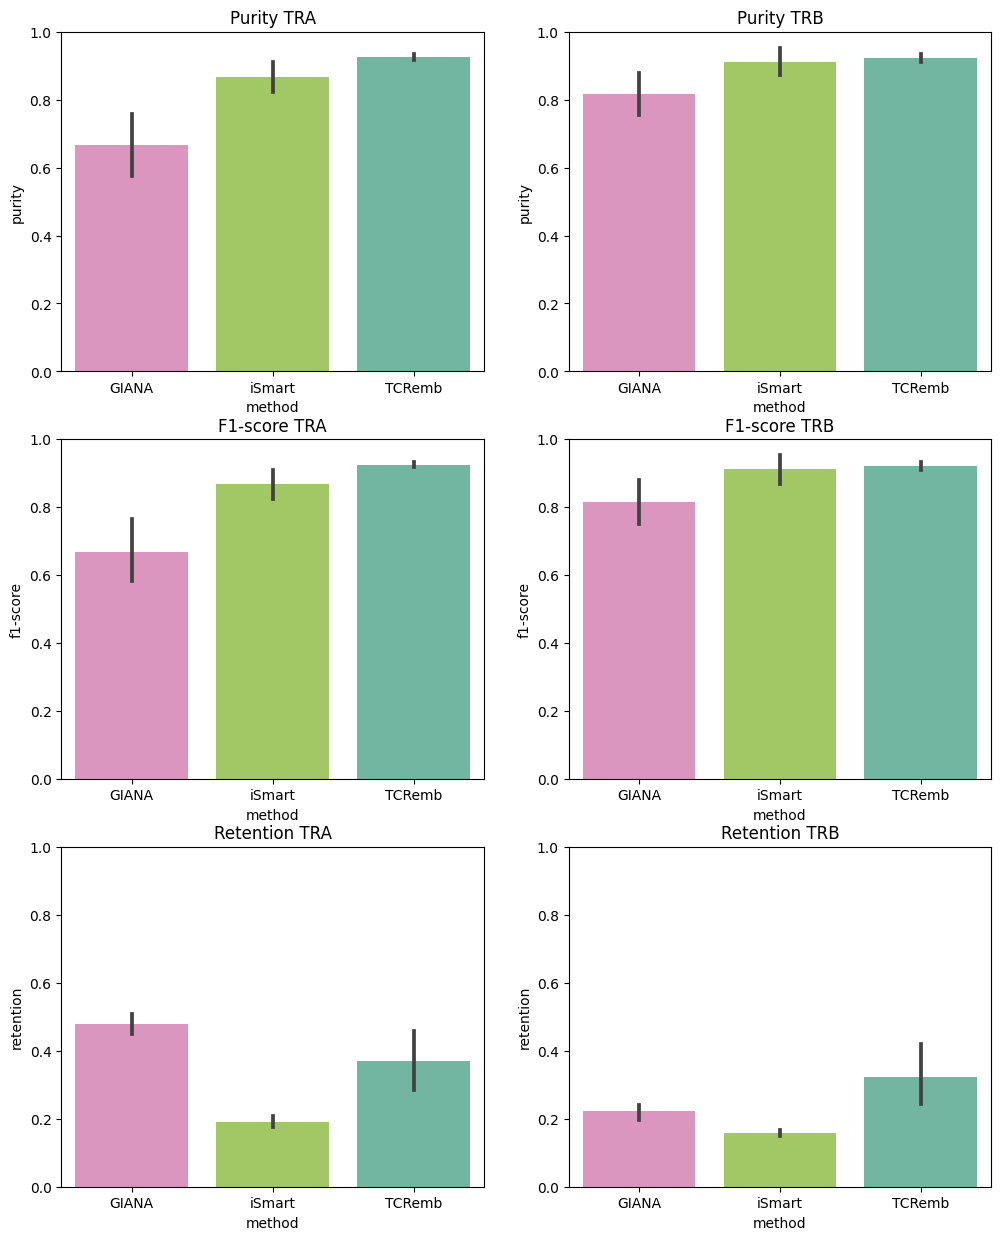

In [134]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [9]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [8]:
!pwd

/home/ykremlyakova/projects/tcr_emb


In [14]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

,0,1,2
0,NLVPMVATV,CASSFPLGGTYEQYF,1
1,NLVPMVATV,CASSLGLDTQYF,1
2,NLVPMVATV,CSARDLDRADNTGELFF,1
3,GTSGSPIVNR,CASLSGRAPQHF,1
4,NLVPMVATV,CASSLNYEQYF,1
...,...,...,...
21628,ELAGIGILTV,CASSPGEARGEQFF,0
21629,TTDPSFLGRY,CASSPGTLSTEAFF,0
21630,QYIKWPWYI,CASSSSFLGNQPQHF,0
21631,NLVPMVATV,CASSRFPTGSNNEQFF,0


In [17]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [19]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [31]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [23]:
#atm_e = atm_e[atm_e['bind']==1]

In [42]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [43]:
roc_res


[{'class': 'CINGVCWTV', 'roc_auc': 0.5752120257985882},
 {'class': 'ELAGIGILTV', 'roc_auc': 0.515489498116114},
 {'class': 'FRDYVDRFYKTLRAEQASQE', 'roc_auc': 0.677350859453994},
 {'class': 'GILGFVFTL', 'roc_auc': 0.5704231955814368},
 {'class': 'GLCTLVAML', 'roc_auc': 0.5417590286425903},
 {'class': 'KRWIILGLNK', 'roc_auc': 0.5725415070242657},
 {'class': 'LLLGIGILV', 'roc_auc': 0.5764722698684963},
 {'class': 'LLWNGPMAV', 'roc_auc': 0.5477210630899155},
 {'class': 'NLVPMVATV', 'roc_auc': 0.5250316938946034},
 {'class': 'PKYVKQNTLKLAT', 'roc_auc': 0.5584946899431166},
 {'class': 'SPRWYFYYL', 'roc_auc': 0.5273414985590779},
 {'class': 'TFEYVSQPFLMDLE', 'roc_auc': 0.730540427314621},
 {'class': 'TPRVTGGGAM', 'roc_auc': 0.6228962818003914},
 {'class': 'TTDPSFLGRY', 'roc_auc': 0.5266290726817043},
 {'class': 'YLQPRTFLL', 'roc_auc': 0.6320013101867017}]

In [30]:
atm_e[atm_e['pred'].isna()]

,antigen.epitope,cdr3aa,bind,pred,4
